# Project: Investigate a Dataset (European Soccer Database)

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

***

<a id='intro'></a>
## Introduction

### The Dataset

The ultimate Soccer database for data analysis and machine learning:

 - +25,000 matches
 - +10,000 players
 - 11 European Countries with their lead championship
 - Seasons 2008 to 2016
 - Players and Teams' attributes sourced from EA Sports' FIFA video game series, including the weekly updates
 - Team line up with squad formation (X, Y coordinates)
 - Betting odds from up to 10 providers
 - Detailed match events (goal types, possession, corner, cross, fouls, cards etc...) for +10,000 matches
 
Source: https://www.kaggle.com/hugomathien/soccer/home


### Questions

There is a lot of data available within the dataset which would provide some interesting analysis. There are detailed match events which, in addition to the match outcome, describe possession, fouls committed, shots on goal and penalties amongst others. For the purpose of this report we will focus on the following areas:


#### 1 - Ages
 - Who were the oldest players to play in the top leagues?
 - Who were the youngest players to play in the top leagues?
 - Which were the oldest teams by average team age?
 - Which were the youngest teams by average team age?

#### 2 - Penalties
 - Which players took the most penalties?
 - Which players scored the most penalties?
 - Which players missed the most penalties?
 - Do players get better at taking penalties with experience?
 - Which goalkeepers faced the most penalties?
 - Which goalkeepers saved the most penalties?
 - Do goalkeepers get better at saving penalties with experience?
 - Which teams conceded the most penalties?

#### 3 - Fouls
 - Which players committed the most fouls?
 - Which players were fouled the most?
 - Which teams committed the most fouls?
 - In which leagues were the most fouls committed?
 - How does age affect player aggressiveness (in terms of fouls committed per game)?

In [1]:
# Set up our environment by importing the necessary libraries

import sqlite3
import pandas as pd
import numpy as np
from datetime import datetime, date
from bs4 import BeautifulSoup # Requires installation of lxml parser

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

colors=['#0343DF','#15b01a','#e50000','#95d0fc','#ed0dd9'] # Define custom palette

***

<a id='wrangling'></a>
## Data Wrangling

### General Properties
First we connect to the database and see what it contains.

In [2]:
# Connect to our database
db=sqlite3.connect("database.sqlite")
cursor=db.cursor()

In [3]:
# What tables does the database contain?
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables=cursor.fetchall()
tables

[(u'sqlite_sequence',),
 (u'Player_Attributes',),
 (u'Player',),
 (u'Match',),
 (u'League',),
 (u'Country',),
 (u'Team',),
 (u'Team_Attributes',)]

In [4]:
# How many records?
for table in tables[1:]: # tables[0] is sqlite internal table
    cursor.execute("SELECT count(id) FROM "+table[0]+";")
    rows=cursor.fetchone()
    print(table[0],rows[0])

(u'Player_Attributes', 183978)
(u'Player', 11060)
(u'Match', 25979)
(u'League', 11)
(u'Country', 11)
(u'Team', 299)
(u'Team_Attributes', 1458)


In [5]:
# Inspect tables and relationships
cursor.execute("SELECT * FROM sqlite_master WHERE type='table';")
tables=cursor.fetchall()
for table in tables[1:]:
    print(table[4])

CREATE TABLE "Player_Attributes" (
	`id`	INTEGER PRIMARY KEY AUTOINCREMENT,
	`player_fifa_api_id`	INTEGER,
	`player_api_id`	INTEGER,
	`date`	TEXT,
	`overall_rating`	INTEGER,
	`potential`	INTEGER,
	`preferred_foot`	TEXT,
	`attacking_work_rate`	TEXT,
	`defensive_work_rate`	TEXT,
	`crossing`	INTEGER,
	`finishing`	INTEGER,
	`heading_accuracy`	INTEGER,
	`short_passing`	INTEGER,
	`volleys`	INTEGER,
	`dribbling`	INTEGER,
	`curve`	INTEGER,
	`free_kick_accuracy`	INTEGER,
	`long_passing`	INTEGER,
	`ball_control`	INTEGER,
	`acceleration`	INTEGER,
	`sprint_speed`	INTEGER,
	`agility`	INTEGER,
	`reactions`	INTEGER,
	`balance`	INTEGER,
	`shot_power`	INTEGER,
	`jumping`	INTEGER,
	`stamina`	INTEGER,
	`strength`	INTEGER,
	`long_shots`	INTEGER,
	`aggression`	INTEGER,
	`interceptions`	INTEGER,
	`positioning`	INTEGER,
	`vision`	INTEGER,
	`penalties`	INTEGER,
	`marking`	INTEGER,
	`standing_tackle`	INTEGER,
	`sliding_tackle`	INTEGER,
	`gk_diving`	INTEGER,
	`gk_handling`	INTEGER,
	`gk_kicking`	INTEGER,
	`gk_p

### Load the Data into Dataframes

In order to answer the questions posed, we can derive all the required information from the following tables:

 - Match
 - Player
 - Team
 - League
 
We will load the above tables into Pandas Dataframes, selecting only those columns that will be required for this analysis.

In [6]:
match_df=pd.read_sql_query('select match_api_id as match_id, \
                               league_id, \
                               season, \
                               date,  \
                               home_team_api_id as home_team_id, \
                               away_team_api_id as away_team_id, \
                               home_team_goal, \
                               away_team_goal, \
                               home_player_1, \
                               home_player_2, \
                               home_player_3, \
                               home_player_4, \
                               home_player_5, \
                               home_player_6, \
                               home_player_7, \
                               home_player_8, \
                               home_player_9, \
                               home_player_10, \
                               home_player_11, \
                               away_player_1, \
                               away_player_2, \
                               away_player_3, \
                               away_player_4, \
                               away_player_5, \
                               away_player_6, \
                               away_player_7, \
                               away_player_8, \
                               away_player_9, \
                               away_player_10, \
                               away_player_11, \
                               goal as goal_events, \
                               foulcommit as foul_events from Match;',db,index_col='match_id')
print(str(len(match_df))+' records loaded.')

25979 records loaded.


In [7]:
player_df=pd.read_sql_query('select player_api_id as player_id, player_name, birthday from Player;',db,index_col='player_id')
print(str(len(player_df))+' records loaded.')

11060 records loaded.


In [8]:
team_df=pd.read_sql_query('select team_api_id as team_id, team_long_name as team_name from Team;',db,index_col='team_id')
print(str(len(team_df))+' records loaded.')

299 records loaded.


In [9]:
league_df=pd.read_sql_query('select id as league_id, name as league_name from League;',db,index_col='league_id')
print(str(len(league_df))+' records loaded.')

11 records loaded.


In [10]:
# Close database connection
db.close()

### Check for Duplicates
Check each table for duplicate records

In [11]:
# Count duplicate match records
match_df.duplicated().sum()

0

In [12]:
# Count duplicate player records
player_df.duplicated().sum()

0

In [13]:
# Count duplicate player names
player_df['player_name'].duplicated().sum()

212

This is expected as many people have the same name. This is also the reason we work with id's instead of names when working with our data.

In [14]:
def top10(df):
    # Function to return top 10 records in dataframe with numbered index
    return df.set_index([range(1,len(df)+1)]).head(10)

In [15]:
# Which names are the most popular?
top10(player_df.groupby(['player_name']).count().rename(columns={'birthday':'occurrences'}) \
    .sort_values(by='occurrences',ascending=False).reset_index()[['player_name','occurrences']])

,player_name,occurrences
1,Danilo,7
2,Paulinho,6
3,Ricardo,5
4,Douglas,4
5,Adriano,4
6,Roberto,4
7,Joao Pedro,4
8,Fernando,4
9,Rafael,4
10,Felipe,4


In [16]:
# Count duplicate team records
team_df.duplicated().sum()

3

In [17]:
# Which teams have been duplicated?
duplicate_teams=team_df.loc[team_df.duplicated(keep=False)==True]
duplicate_teams

,team_name
team_id,
9996,Royal Excel Mouscron
274581,Royal Excel Mouscron
8031,Polonia Bytom
8020,Polonia Bytom
8244,Widzew Łódź
8024,Widzew Łódź


In [18]:
# Which leagues do these duplicate teams belong to?
duplicates_ids=list(duplicate_teams.index)
league_ids=match_df[(match_df['home_team_id'].isin(duplicates_ids))]['league_id'].unique()
league_df[(league_df.index.isin(league_ids))]

,league_name
league_id,
1,Belgium Jupiler League
15722,Poland Ekstraklasa


In [19]:
# Count duplicate league records
league_df.duplicated().sum()

0

The only duplicate records we found were in the teams table, as detailed above. We will look at the rest of the data before deciding how to deal with this.

### Check for Missing Data
Check each table for missing entries

In [20]:
# Count missing league data
league_df.isnull().sum()

league_name    0
dtype: int64

In [21]:
# Count missing team data
team_df.isnull().sum()

team_name    0
dtype: int64

In [22]:
# Count missing player data
player_df.isnull().sum()

player_name    0
birthday       0
dtype: int64

In [23]:
# Count missing match data
match_df.isnull().sum()

league_id             0
season                0
date                  0
home_team_id          0
away_team_id          0
home_team_goal        0
away_team_goal        0
home_player_1      1224
home_player_2      1315
home_player_3      1281
home_player_4      1323
home_player_5      1316
home_player_6      1325
home_player_7      1227
home_player_8      1309
home_player_9      1273
home_player_10     1436
home_player_11     1555
away_player_1      1234
away_player_2      1278
away_player_3      1293
away_player_4      1321
away_player_5      1335
away_player_6      1313
away_player_7      1235
away_player_8      1341
away_player_9      1328
away_player_10     1441
away_player_11     1554
goal_events       11762
foul_events       11762
dtype: int64

The match events seem to be the most incomplete dataset. We will take a look at the distribution of the recorded match events first.

In [24]:
# Add league name
matches_df=pd.merge(match_df.reset_index(),league_df.reset_index(),how='left',on='league_id')

In [25]:
# Match events % completeness by league by season
match_count=matches_df.groupby(['league_name','season']).count()['date']
events_completeness=((matches_df.groupby(['league_name','season']).count()['goal_events']/match_count)*100).round(2).unstack()
events_completeness

season,2008/2009,2009/2010,2010/2011,2011/2012,2012/2013,2013/2014,2014/2015,2015/2016
league_name,,,,,,,,
Belgium Jupiler League,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00
England Premier League,100.00,100.00,100.00,100.00,100.00,100.0,100.00,100.00
France Ligue 1,0.00,0.00,61.32,71.84,100.00,100.0,100.00,100.00
Germany 1. Bundesliga,100.00,100.00,100.00,100.00,100.00,100.0,100.00,100.00
Italy Serie A,100.00,99.74,99.74,100.00,99.74,100.0,100.00,100.00
Netherlands Eredivisie,0.65,1.31,1.31,2.29,0.00,0.0,67.65,100.00
Poland Ekstraklasa,0.00,0.00,0.00,2.92,0.00,0.0,0.00,0.00
Portugal Liga ZON Sagres,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00
Scotland Premier League,1.32,1.75,1.75,0.88,0.00,0.0,0.00,0.00


Some of the leagues have very little match event data.  We will restrict our analysis to only include those leagues for which there is a large enough sample of data.  Therefore, we will create a subset of match data for the following leagues:

- England Premier League
- France Ligue 1
- Germany 1. Bundesliga
- Italy Serie A
- Spain LIGA BBVA

Since the duplicate teams we found earlier do not belong to these leagues, we can ignore them.

In [26]:
# Create a subset of match data
league_list=['England Premier League','France Ligue 1','Germany 1. Bundesliga','Italy Serie A','Spain LIGA BBVA']
match_subset_df=matches_df[(matches_df['league_name'].isin(league_list))]
print('Selected subset of match data contains '+str(len(match_subset_df))+' matches')

Selected subset of match data contains 14585 matches


In [27]:
# Count missing subset match data
match_subset_df.isnull().sum()

match_id             0
league_id            0
season               0
date                 0
home_team_id         0
away_team_id         0
home_team_goal       0
away_team_goal       0
home_player_1       38
home_player_2       47
home_player_3       40
home_player_4       44
home_player_5       38
home_player_6       34
home_player_7       52
home_player_8       44
home_player_9       34
home_player_10      73
home_player_11      62
away_player_1       29
away_player_2       49
away_player_3       46
away_player_4       46
away_player_5       44
away_player_6       45
away_player_7       43
away_player_8       55
away_player_9       47
away_player_10      62
away_player_11      72
goal_events       1018
foul_events       1018
league_name          0
dtype: int64

It is evident that some players are missing from the team line-ups (*NULL* values). We are told that this is because the creator of the dataset was not able to source their attributes from FIFA. The missing match events are mostly from *France Ligue 1*, from 2008-2012. Since we are mainly interested in the match events, we will remove rows which don't contain match event data.

In [28]:
# Remove rows with missing match events
match_subset_df=match_subset_df.dropna(subset=['goal_events','foul_events'])
print('Selected subset of match data now contains '+str(len(match_subset_df))+' matches')

Selected subset of match data now contains 13567 matches


In [29]:
# Stack the match data to get all teams in the same column
home_matches=match_subset_df[['league_name','home_team_id','season','date']].rename(columns={'home_team_id':'team_id'})
away_matches=match_subset_df[['league_name','away_team_id','season','date']].rename(columns={'away_team_id':'team_id'})
all_matches=pd.concat([home_matches,home_matches],join="inner")

In [30]:
# Add team name
all_matches=all_matches.merge(team_df.reset_index(),how='left',on='team_id')

In [31]:
# How many matches has each team played per season?
matches_per_season=all_matches.groupby(['league_name','team_name','season']).count()['date']
matches_per_season.unstack().head()

season                                   2008/2009  2009/2010  2010/2011  \
league_name            team_name                                           
England Premier League Arsenal                38.0       38.0       38.0   
                       Aston Villa            38.0       38.0       38.0   
                       Birmingham City         NaN       38.0       38.0   
                       Blackburn Rovers       38.0       38.0       38.0   
                       Blackpool               NaN        NaN       38.0   

season                                   2011/2012  2012/2013  2013/2014  \
league_name            team_name                                           
England Premier League Arsenal                38.0       38.0       38.0   
                       Aston Villa            38.0       38.0       38.0   
                       Birmingham City         NaN        NaN        NaN   
                       Blackburn Rovers       38.0        NaN        NaN   
                       Blackpool               NaN        NaN        NaN   

season                                   2014/2015  2015/2016  
league_name            team_name                               
England Premier League Arsenal                38.0       38.0  
                       Aston Villa            38.0       38.0  
                       Birmingham City         NaN        NaN  
                       Blackburn Rovers        NaN        NaN  
                       Blackpool               NaN        NaN

Lots of entries are missing from this table. The reason for this is that the teams who finish lowest in the league get relegated to a lower league, and new teams get promoted to the top league. So while the number of teams in each league should remain constant, and hence the number of matches played, the actual teams will change from season to season.

In [32]:
# How many matches in each league per season?
matches_per_league_per_season=all_matches.groupby(['league_name','season']).count()['date'].unstack()
matches_per_league_per_season['expected_matches']=matches_per_league_per_season.max(axis=1)
matches_per_league_per_season

season,2008/2009,2009/2010,2010/2011,2011/2012,2012/2013,2013/2014,2014/2015,2015/2016,expected_matches
league_name,,,,,,,,,
England Premier League,760.0,760.0,760.0,760.0,760.0,760.0,760.0,760.0,760.0
France Ligue 1,NaN,NaN,466.0,546.0,760.0,760.0,760.0,760.0,760.0
Germany 1. Bundesliga,612.0,612.0,612.0,612.0,612.0,612.0,612.0,612.0,612.0
Italy Serie A,760.0,758.0,758.0,716.0,758.0,760.0,758.0,760.0,760.0
Spain LIGA BBVA,760.0,760.0,758.0,760.0,760.0,760.0,760.0,760.0,760.0


There is missing data for *France Ligue 1* from 2008-2012, which we removed earlier due to missing match events. There is also missing data for *Italy Serie A* and *Spain LIGA BBVA*. The remaining data is sufficient for our analysis.

### Data Processing

We need to extract the data for penalties and fouls from the the match events columns.

#### Penalties

The penalties are recorded in the goal_events column in xml format:

In [33]:
# Use Beautifulsoup to extract xml data, for example:
txt=match_subset_df['goal_events'].dropna().iloc[0]
soup=BeautifulSoup(txt,"xml")
event=soup.find("value")
print(event.prettify())

<value>
 <comment>
  n
 </comment>
 <stats>
  <goals>
   1
  </goals>
  <shoton>
   1
  </shoton>
 </stats>
 <event_incident_typefk>
  406
 </event_incident_typefk>
 <elapsed>
  22
 </elapsed>
 <player2>
  38807
 </player2>
 <subtype>
  header
 </subtype>
 <player1>
  37799
 </player1>
 <sortorder>
  5
 </sortorder>
 <team>
  10261
 </team>
 <id>
  378998
 </id>
 <n>
  295
 </n>
 <type>
  goal
 </type>
 <goal_type>
  n
 </goal_type>
</value>



In [34]:
def penalties(goal_events):
    # Return list of penalties from the supplied xml string [scored,player_id,team_id]
    # player1=player_id
    # team=team_id
    pens=[]
    events=BeautifulSoup(goal_events,"xml").find_all("value")
    for i in range(len(events)):
        event=events[i]
        if event.find("comment")==None: # ignore blank entries
            continue
        elif event.find("comment").string=='p':  # penalty scored
            p=event.find("player1")
            t=event.find("team")
            if p==None or t==None: # ignore entries that have player or team missing
                continue
            pens.append([True,int(p.string),int(t.string)])
        elif event.find("comment").string=='npm': # penalty missed/saved
            p=event.find("player1")
            t=event.find("team")
            if p==None or t==None: # ignore entries that have player or team missing
                continue
            pens.append([False,int(p.string),int(t.string)])
    return pens

We know that some players are missing from the team lineups. We will remove any penalty events that contain *NULL* values for either goalkeeper.

In [35]:
# Remove all Null values
pen_subset_df=match_subset_df[['match_id','home_team_id','home_player_1','away_team_id','away_player_1','goal_events']].dropna()

In [36]:
# Build table of penalty events [match_id,player_id,team_id,opponent_id,scored]
penalties_list=[]
for row_index,row in pen_subset_df.iterrows():
    if row['goal_events']!=None:
        pens=penalties(row['goal_events'])
        for pen in pens:
            home=row['home_team_id'],row['home_player_1']
            away=row['away_team_id'],row['away_player_1']
            opponent,keeper=[x for x in [home,away] if x[0]!=pen[2]][0]
            keeper=int(float(keeper))
            penalties_list.append([row['match_id'],pen[1],pen[2],opponent,keeper,pen[0]])
cols=['match_id','player_id','team_id','opponent_id','keeper_id','scored']
penalties_df=pd.DataFrame(penalties_list,columns=cols)

In [37]:
print('Total number of penalties taken: '+str(len(penalties_df.index)))

Total number of penalties taken: 3516


We will also remove any penalties taken by unknown players, i.e. players we do not have details for.

In [38]:
# We use an inner join to only include penalties by players we have details for
penalties_df=penalties_df.merge(player_df.reset_index(),how='inner',on='player_id') \
    .drop(labels=['player_name','birthday'],axis=1)

In [39]:
total_penalties=len(penalties_df.index)
print('Total number of penalties taken by known players: '+str(total_penalties))

Total number of penalties taken by known players: 3498


In [40]:
total_scored=len(penalties_df['scored'].loc[penalties_df['scored']==True])
total_missed=total_penalties-total_scored
total_goals=match_subset_df['home_team_goal'].sum()+match_subset_df['away_team_goal'].sum()
other_goals=total_goals-total_scored

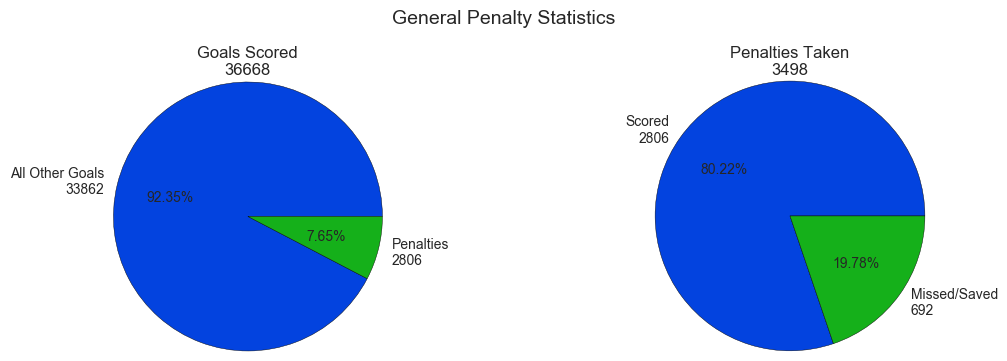

In [41]:
plt.figure(figsize=(12,4))
plt.suptitle('General Penalty Statistics',fontsize=14)
# Left plot
plt.subplot(1,2,1)
labels='All Other Goals\n'+str(other_goals),'Penalties\n'+str(total_scored)
data=[(total_goals-total_scored),total_scored]
plt.pie(data,labels=labels,colors=colors,autopct='%.2f%%')
plt.title('Goals Scored\n'+str(total_goals))
plt.axis('equal')
# Right plot
plt.subplot(1,2,2)
labels='Scored\n'+str(total_scored),'Missed/Saved\n'+str(total_missed)
data=[total_scored,total_missed]
plt.pie(data,labels=labels,colors=colors,autopct='%.2f%%')
plt.title('Penalties Taken\n'+str(total_penalties))
plt.axis('equal')
plt.subplots_adjust(wspace=0.4,top=0.8)
plt.show()

#### Fouls

The fouls are recorded in the foul_events column in xml format:

In [42]:
# Use Beautifulsoup to extract xml data, for example:
txt=match_df['foul_events'].dropna().iloc[0]
soup = BeautifulSoup(txt, "xml")
event=soup.find("value")
print(event.prettify())

<value>
 <stats>
  <foulscommitted>
   1
  </foulscommitted>
 </stats>
 <event_incident_typefk>
  37
 </event_incident_typefk>
 <elapsed>
  1
 </elapsed>
 <player2>
  32569
 </player2>
 <player1>
  25518
 </player1>
 <sortorder>
  1
 </sortorder>
 <team>
  10261
 </team>
 <n>
  267
 </n>
 <type>
  foulcommit
 </type>
 <id>
  378824
 </id>
</value>



In [43]:
def fouls_committed(foul_events):
    # Return list of fouls committed from the supplied xml string [player_id,team_id,opponent_id]
    # player1=player_id
    # player2=opponent_id
    # team=team_id
    fouls=[]
    events=BeautifulSoup(foul_events,"xml").find_all("value")
    for i in range(len(events)):
        event=events[i]
        if event.find("foulscommitted")==None: # ignore blank entries
            continue
        elif event.find("foulscommitted").string=='1': # foul committed
            p=event.find("player1")
            t=event.find("team")
            o=event.find("player2")
            if p==None or o==None or t==None: # ignore entries that have player or team missing
                continue
            elif p.string=='Unknown player' or o.string=='Unknown player': # ignore entries that have 'Unknown player'
                continue
            fouls.append([int(p.string),int(t.string),int(o.string)])
    return fouls

In [44]:
# Build table of foul events [match_id,player_id,team_id,league_id,opponent_id]
fouls_list=[]
for row_index,row in match_subset_df.iterrows():
    if row['foul_events']!=None:
        fouls=fouls_committed(row['foul_events'])
        for foul in fouls:
            fouls_list.append([row['match_id'],foul[0],foul[1],row['league_id'],foul[2]])
cols=['match_id','player_id','team_id','league_id','opponent_id']
fouls_df=pd.DataFrame(fouls_list,columns=cols)

In [45]:
print('Total number of fouls committed: '+str(len(fouls_df.index)))

Total number of fouls committed: 180352


We will remove any fouls committed by unknown players, i.e. players we do not have details for.

In [46]:
# We use an inner join to only include fouls committed by players we have details for
fouls_df=fouls_df.merge(player_df.reset_index(),how='inner',on='player_id').drop(labels=['player_name','birthday'],axis=1)

In [47]:
print('Total number of fouls committed by known players: '+str(len(fouls_df.index)))

Total number of fouls committed by known players: 179353


#### Appearances
Our match data contains team and player id's spread over several columns. To fascilitate the merging and joining of our dataframes on players and teams, we need to restructure our match data and create a table of player appearances with players and teams in single columns.

In [48]:
match_subset_df.set_index('match_id',inplace=True)

In [49]:
# Subsets of player id's
home_players_df=match_subset_df.loc[:,'home_player_1':'home_player_11']
away_players_df=match_subset_df.loc[:,'away_player_1':'away_player_11']

In [50]:
# Stack player id's in a single column, removing any missing entries
home_players_df=home_players_df.stack(dropna=True).astype(int).reset_index() \
    .drop(labels='level_1',axis=1).rename(columns={0:'player_id'})
away_players_df=away_players_df.stack(dropna=True).astype(int).reset_index() \
    .drop(labels='level_1',axis=1).rename(columns={0:'player_id'})

In [51]:
# Subsets of team id's
home_teams_df=match_subset_df[['home_team_id']].reset_index()
away_teams_df=match_subset_df[['away_team_id']].reset_index()

In [52]:
# Appearances for home and away matches
home_appearances_df=pd.merge(home_teams_df,home_players_df,on=['match_id'],how='inner') \
    .set_index(['match_id']).rename(columns={'home_team_id':'team_id'})
away_appearances_df=pd.merge(away_teams_df,away_players_df,on=['match_id'],how='inner') \
    .set_index(['match_id']).rename(columns={'away_team_id':'team_id'})

In [53]:
# All appearances
appearances_df=home_appearances_df.append(away_appearances_df).reset_index()

We only have the starting line-ups recorded for each team in the dataset so if a substitute takes a penalty they won't be recorded as playing in that particular match. There will be substitutes who have taken penalties or committed fouls that won't be in the appearance table. We need to add these in order to relate them to their respective teams and matches.

In [54]:
# Add penalty and foul players to appearance table
cols=['match_id','team_id','player_id']
appearances_df=pd.concat([appearances_df,penalties_df[cols],fouls_df[cols]],ignore_index=True)

There will be occaisions when a player takes more than 1 penalty and/or committs several fouls in the same match. There will also be players added who were already in the appearance table. We need to check for and remove any duplicates that now exist in the appearance table.

In [55]:
# Multiple penalties by the same player in the same match
penalties_df[cols].duplicated().sum()

132

In [56]:
# Multiple fouls by the same player in the same match
fouls_df[cols].duplicated().sum()

70215

In [57]:
# Count duplicate appearance records
appearances_df.duplicated().sum()

170587

In [58]:
# Remove duplicate appearance records
appearances_df.drop_duplicates(inplace=True)

Each player should now only appear once in each match. We use this fact to check for consistency in our final appearance table.

In [59]:
# Multiple appearances in the same match
appearances_df[['player_id','match_id']].duplicated().sum()

5

There are erroneous entries in our appearance table, with players recorded as playing for different teams in the same match. We will remove these entries.

In [60]:
# Multiple appearances in the same match
duplicates_df=appearances_df.loc[appearances_df[['player_id','match_id']].duplicated()]

In [61]:
# Remove multiple appearances in the same match
appearances_df=appearances_df[~appearances_df.index.isin(duplicates_df.index)]

In [62]:
print('Total number of unique player appearances: '+str(len(appearances_df.index)))

Total number of unique player appearances: 309795


In [63]:
# Total appearances for each player
total_appearances_df=appearances_df.groupby('player_id').count()[['match_id']].rename(columns={'match_id':'appearances'})
total_appearances_df=total_appearances_df.sort_values(by='appearances',ascending=False)
top10(total_appearances_df.reset_index() \
      .merge(player_df.reset_index(),how='inner',on='player_id')[['player_name','appearances']])

,player_name,appearances
1,Samir Handanovic,286
2,Gorka Iraizoz Moreno,286
3,Tim Howard,282
4,Joe Hart,275
5,Cristiano Ronaldo,260
6,Marek Hamsik,260
7,Gareth Barry,260
8,Borja Valero,258
9,Manuel Neuer,255
10,Lionel Messi,254


In [64]:
total_appearances_df[['appearances']].describe().round(2).transpose()

,count,mean,std,min,25%,50%,75%,max
appearances,5936.0,52.19,54.55,1.0,10.0,31.0,78.0,286.0


In [65]:
def most_common(ds):
    # Return value and count of most common in series
    value=ds.mode()[0]
    count=ds[ds==value].count()
    return (value,count)

In [66]:
# Most common number of appearances
value,count=most_common(total_appearances_df['appearances'])
print(str(count)+' players only played '+str(value)+' match,'+ \
      ' which was the most common number of appearances per player')

336 players only played 1 match, which was the most common number of appearances per player


In [67]:
def plot_hist2(data,heading,title1,title2,xlabel,ylabel):
    # Generic function to create side-by-side plot of data and top 10 values
    plt.figure(figsize=(12,4))
    plt.suptitle(heading,fontsize=14)
    # Left plot
    plt.subplot(1,2,1)
    data.hist()
    plt.title(title1)
    plt.ylabel(xlabel)
    plt.xlabel(ylabel)
    plt.axvline(data.median(),color='k',linestyle='-',linewidth=2,label='Median')
    plt.axvline(data.mean(),color='k',linestyle='--',linewidth=2,label='Mean')
    plt.legend()
    # Right plot
    plt.subplot(1,2,2)
    data.head(10).hist()
    plt.title(title2)
    plt.ylabel(xlabel)
    plt.xlabel(ylabel)
    plt.subplots_adjust(wspace=0.4,top=0.8)
    plt.show()
    return

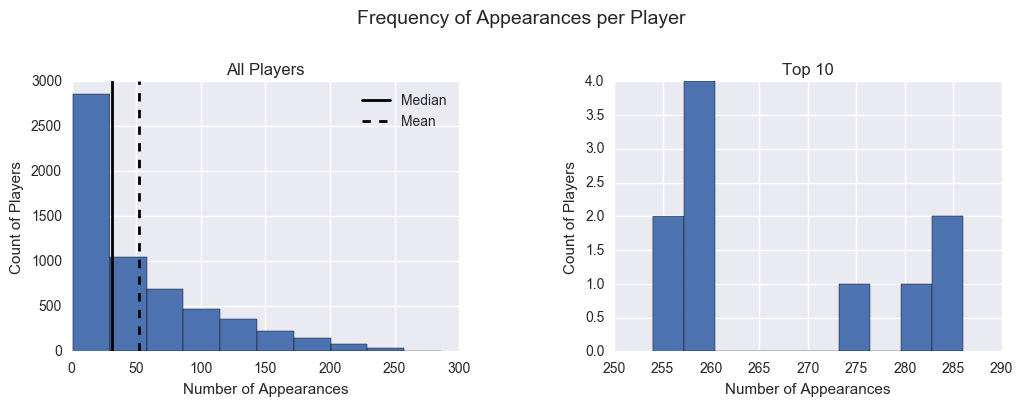

In [68]:
plot_hist2(total_appearances_df['appearances'],'Frequency of Appearances per Player', \
          'All Players','Top 10','Count of Players','Number of Appearances')

In [69]:
match_subset_df.reset_index(inplace=True)

#### Player Ages

In [70]:
def parse_date(date):
    # Convert date to Python datetime
    return datetime.strptime(date,'%Y-%m-%d %H:%M:%S')

In [71]:
def calculate_age_in_days(date_of_event,date_of_birth):
    # Return the number of days between two dates
    return (date_of_event-date_of_birth).days

In [72]:
def calculate_age_in_years(date_of_event,date_of_birth):
    # Return the number of years between two dates
    return date_of_event.year-date_of_birth.year \
        -((date_of_event.month,date_of_event.day)<(date_of_birth.month,date_of_birth.day))

In [73]:
# Convert dates to Python datetime
match_subset_df['date']=match_subset_df['date'].apply(parse_date)
player_df['birthday']=player_df['birthday'].apply(parse_date)

In [74]:
# Add player data
appearances_df=pd.merge(appearances_df.reset_index(),player_df.reset_index(),how='inner',on='player_id')

In [75]:
# Add league and date
appearances_df=pd.merge(appearances_df,match_subset_df[['match_id','date','league_id']],how='inner',on='match_id')

In [76]:
# Calculate age in days
appearances_df['age_in_days']=appearances_df.apply(lambda x: calculate_age_in_days(x['date'],x['birthday']),axis=1)

In [77]:
# Calculate age in years
appearances_df['age_in_years']=appearances_df.apply(lambda x: calculate_age_in_years(x['date'],x['birthday']),axis=1)

In [78]:
# Add team names and league names
appearances_df=appearances_df.merge(team_df.reset_index(),how='left',on='team_id') \
    .merge(league_df.reset_index(),how='left',on='league_id')

In [79]:
# Player ages by appearance
# We will use max() since there is only 1 value per match
player_ages_df=appearances_df.groupby(['player_id','match_id'])[['age_in_days','age_in_years']].max()
player_ages_df.describe().round(2).transpose()

,count,mean,std,min,25%,50%,75%,max
age_in_days,309795.0,9904.58,1458.52,5956.0,8818.0,9835.0,10908.0,15575.0
age_in_years,309795.0,26.61,4.01,16.0,24.0,26.0,29.0,42.0


In [80]:
# Most common player age
value,count=most_common(player_ages_df['age_in_years'])
print(str(count)+' players were '+str(value)+' years old on match day,'+ \
      ' which was the most common player age')

28596 players were 25 years old on match day, which was the most common player age


In [81]:
def plot_hist1(data,heading,xlabel,ylabel):
    # Generic function to create single plot of data
    plt.suptitle(heading,fontsize=14)
    data.hist()
    plt.ylabel(xlabel)
    plt.xlabel(ylabel)
    plt.axvline(data.median(),color='k',linestyle='-',linewidth=2,label='Median')
    plt.axvline(data.mean(),color='k',linestyle='--',linewidth=2,label='Mean')
    plt.legend()
    plt.show()
    return

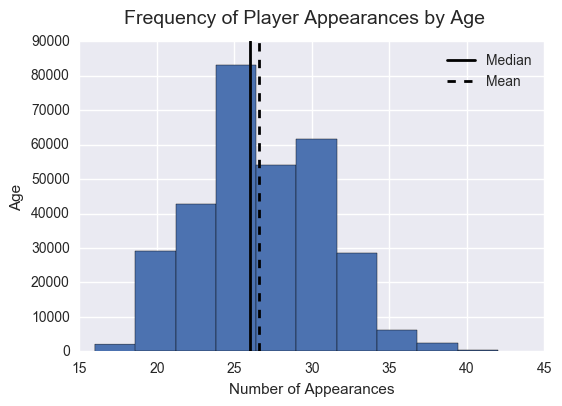

In [82]:
plot_hist1(player_ages_df['age_in_years'],'Frequency of Player Appearances by Age','Age','Number of Appearances')

***

<a id='eda'></a>
## Exploratory Data Analysis

### Research Area 1 - Ages

#### Oldest Players
Who were the oldest players to play in the top leagues?

In [83]:
# Maximum player ages
player_ages_max_df=appearances_df.groupby(['player_id']).max()
player_ages_max_df.sort_values(by='age_in_days',ascending=False,inplace=True)
top10(player_ages_max_df[['player_name','team_name','league_name','date','age_in_days','age_in_years']])

,player_name,team_name,league_name,date,age_in_days,age_in_years
1,Francesco Antonioli,Cesena,Italy Serie A,2012-05-06,15575,42
2,Brad Friedel,Tottenham Hotspur,England Premier League,2013-11-10,15517,42
3,Mark Schwarzer,Leicester City,England Premier League,2015-03-14,15499,42
4,Alberto Fontana,Palermo,Italy Serie A,2008-11-15,15272,41
5,Jens Lehmann,VfB Stuttgart,Germany 1. Bundesliga,2011-04-10,15126,41
6,Paolo Maldini,Milan,Italy Serie A,2009-05-31,14949,40
7,Juan Carlos Valeron,UD Las Palmas,Spain LIGA BBVA,2016-05-08,14936,40
8,Javier Zanetti,Inter,Italy Serie A,2014-05-18,14891,40
9,Edwin van der Sar,Manchester United,England Premier League,2011-05-22,14815,40
10,Manuel Pablo,RC Deportivo de La Coruña,Spain LIGA BBVA,2016-05-14,14720,40


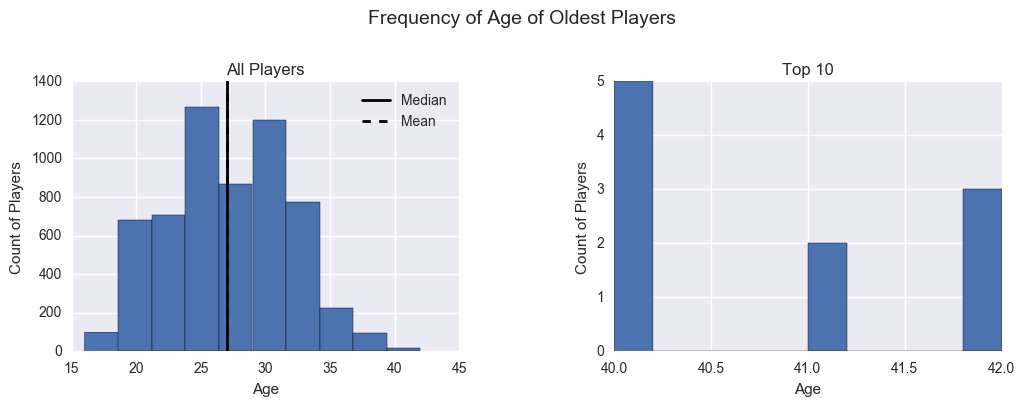

In [84]:
plot_hist2(player_ages_max_df['age_in_years'],'Frequency of Age of Oldest Players', \
          'All Players','Top 10','Count of Players','Age')

#### Youngest Players
Who were the youngest players to play in the top leagues?

In [85]:
# Minimum player ages
player_ages_min_df=appearances_df.groupby(['player_id']).min()
player_ages_min_df.sort_values(by='age_in_days',ascending=True,inplace=True)
top10(player_ages_min_df[['player_name','team_name','league_name','date','age_in_days','age_in_years']])

,player_name,team_name,league_name,date,age_in_days,age_in_years
1,Fabrice Olinga,Málaga CF,Spain LIGA BBVA,2012-09-01,5956,16
2,Isaiah Brown,West Bromwich Albion,England Premier League,2013-05-04,5961,16
3,Mbaye Niang,Genoa,France Ligue 1,2011-05-01,5977,16
4,Neal Maupay,AS Saint-Étienne,France Ligue 1,2013-02-09,6023,16
5,Jose Baxter,Everton,England Premier League,2008-08-23,6042,16
6,Reece Oxford,West Ham United,England Premier League,2015-08-09,6080,16
7,Gianluigi Donnarumma,Milan,Italy Serie A,2015-10-25,6086,16
8,Juanmi,Málaga CF,England Premier League,2010-01-24,6093,16
9,Iker Muniain,Athletic Club de Bilbao,Spain LIGA BBVA,2009-08-30,6098,16
10,Alban Lafont,Toulouse FC,France Ligue 1,2015-11-28,6153,16


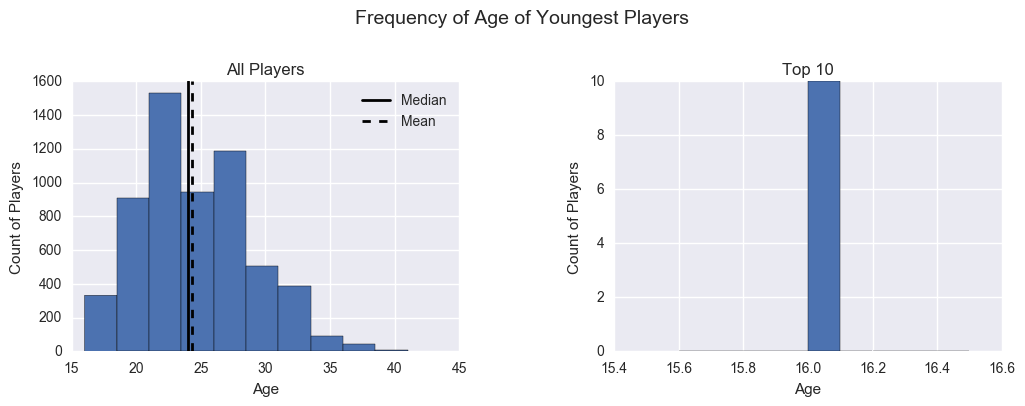

In [86]:
plot_hist2(player_ages_min_df['age_in_years'],'Frequency of Age of Youngest Players', \
          'All Players','Top 10','Count of Players','Age')

In [87]:
# Mean player ages
player_ages_mean_df=appearances_df.groupby(['player_id']).mean()

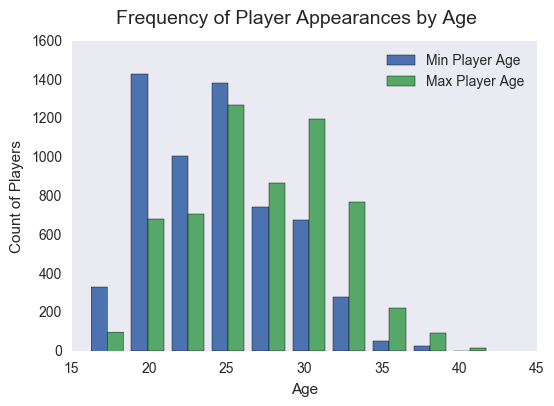

In [88]:
plt.hist([player_ages_min_df['age_in_years'],player_ages_max_df['age_in_years']], \
         histtype='bar',label=['Min Player Age','Max Player Age'])
plt.legend()
plt.suptitle('Frequency of Player Appearances by Age',fontsize=14)
plt.ylabel('Count of Players')
plt.xlabel('Age')
plt.grid()
plt.show()

#### Teams Ages

We know some of the players are missing from the line-ups, so if we assume the missing players' ages were equal to the average age for the team, then the team average won't be affected.

In [89]:
# Mean team ages
team_ages_mean_df=appearances_df.groupby(['team_name','match_id'])[['age_in_days','age_in_years']].mean()
team_ages_mean_df.describe().round(2).transpose()

,count,mean,std,min,25%,50%,75%,max
age_in_days,27134.0,9905.17,536.00,7898.36,9535.36,9900.23,10260.06,12274.45
age_in_years,27134.0,26.62,1.47,21.09,25.64,26.64,27.58,33.09


In [90]:
# Most common team mean age
value,count=most_common(team_ages_mean_df['age_in_years'])
print(str(count)+' teams had a mean age of '+str(value)+' years,'+ \
      ' which was the most common mean team age')

629 teams had a mean age of 27.0 years, which was the most common mean team age


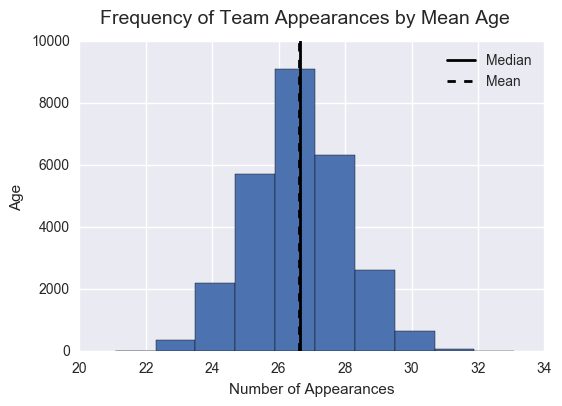

In [91]:
plot_hist1(team_ages_mean_df['age_in_years'],'Frequency of Team Appearances by Mean Age','Age','Number of Appearances')

#### Oldest Teams
Which were the oldest teams by average team age?

It is logical that the oldest team to play a specific match would be even older for any subsequent match. Therefore we shall look at the oldest teams by team rather than by each match.

In [92]:
# Oldest Team
team_ages_max_df=team_ages_mean_df.reset_index().groupby(['team_name']).max().sort_values(by='age_in_days',ascending=False)
top10(team_ages_max_df[['age_in_days','age_in_years']].round(2).reset_index())

,team_name,age_in_days,age_in_years
1,Milan,12274.45,33.09
2,Chievo Verona,12091.33,32.67
3,Bologna,11925.42,32.08
4,Portsmouth,11792.27,31.82
5,Levante UD,11783.18,31.82
6,Fulham,11720.91,31.55
7,Inter,11692.64,31.55
8,Hellas Verona,11633.64,31.36
9,Juventus,11612.73,31.18
10,Cesena,11483.00,31.00


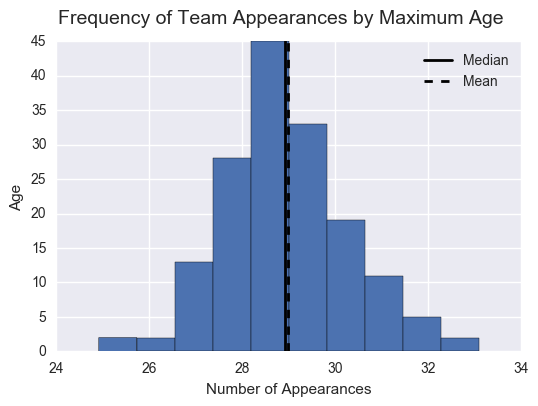

In [93]:
plot_hist1(team_ages_max_df['age_in_years'],'Frequency of Team Appearances by Maximum Age','Age','Number of Appearances')

#### Youngest Teams
Which were the youngest teams by average team age?

In [94]:
# Youngest Team
team_ages_min_df=team_ages_mean_df.reset_index().groupby(['team_name']).min().sort_values(by='age_in_days',ascending=True)
top10(team_ages_min_df[['age_in_days','age_in_years']].round(2).reset_index())

,team_name,age_in_days,age_in_years
1,OGC Nice,7898.36,21.09
2,SpVgg Greuther Fürth,8228.36,22.00
3,Arsenal,8256.33,22.25
4,Toulouse FC,8273.50,22.08
5,Borussia Dortmund,8307.82,22.27
6,Girondins de Bordeaux,8334.00,22.25
7,TSG 1899 Hoffenheim,8352.18,22.27
8,Udinese,8353.91,22.27
9,SV Werder Bremen,8385.54,22.54
10,Reggio Calabria,8398.80,22.60


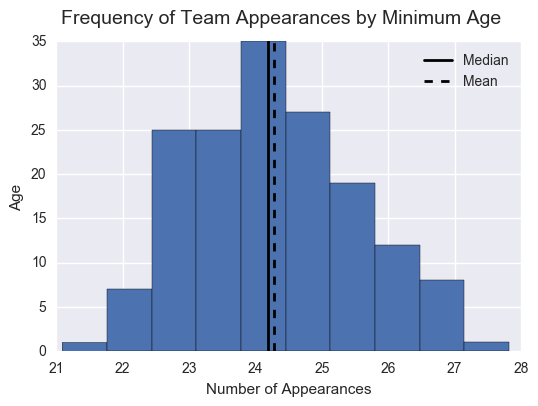

In [95]:
plot_hist1(team_ages_min_df['age_in_years'],'Frequency of Team Appearances by Minimum Age','Age','Number of Appearances')

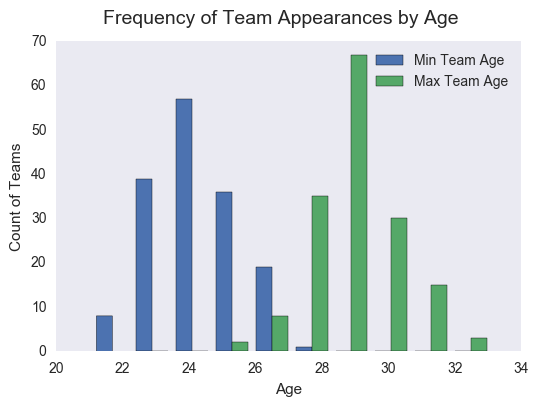

In [96]:
plt.hist([team_ages_min_df['age_in_years'],team_ages_max_df['age_in_years']], \
         histtype='bar',label=['Min Team Age','Max Team Age'])
plt.legend()
plt.suptitle('Frequency of Team Appearances by Age',fontsize=14)
plt.ylabel('Count of Teams')
plt.xlabel('Age')
plt.grid()
plt.show()

### Research Area 2 - Penalties

#### Penalties Taken
Which players took the most penalties?

In [97]:
# Count number of penalties taken by each player
taken_penalties_df=penalties_df.groupby('player_id').count()
taken_penalties_df.sort_values(by='match_id',ascending=False,inplace=True)

In [98]:
# Add player data
taken_penalties_df=taken_penalties_df.reset_index().merge(player_df.reset_index(),how='inner',on='player_id') \
    .rename(columns={'scored':'taken'})
top10(taken_penalties_df[['player_name','taken']])

,player_name,taken
1,Cristiano Ronaldo,62
2,Zlatan Ibrahimovic,45
3,Lionel Messi,44
4,Antonio Di Natale,36
5,Francesco Totti,33
6,Frank Lampard,31
7,Edinson Cavani,31
8,Sejad Salihovic,30
9,Steven Gerrard,29
10,Diego Milito,27


In [99]:
penalty_takers=len(taken_penalties_df.index)
print('Total number of players who have taken penalties: '+str(penalty_takers))

Total number of players who have taken penalties: 868


In [100]:
taken_penalties_df[['taken']].describe().round(2).transpose()

,count,mean,std,min,25%,50%,75%,max
taken,868.0,4.03,5.34,1.0,1.0,2.0,5.0,62.0


In [101]:
# Most common number of penalties taken
value,count=most_common(taken_penalties_df['taken'])
print(str(count)+' players took '+str(value)+' penalty,'+ \
      ' which was the most common number of penalties taken')

357 players took 1 penalty, which was the most common number of penalties taken


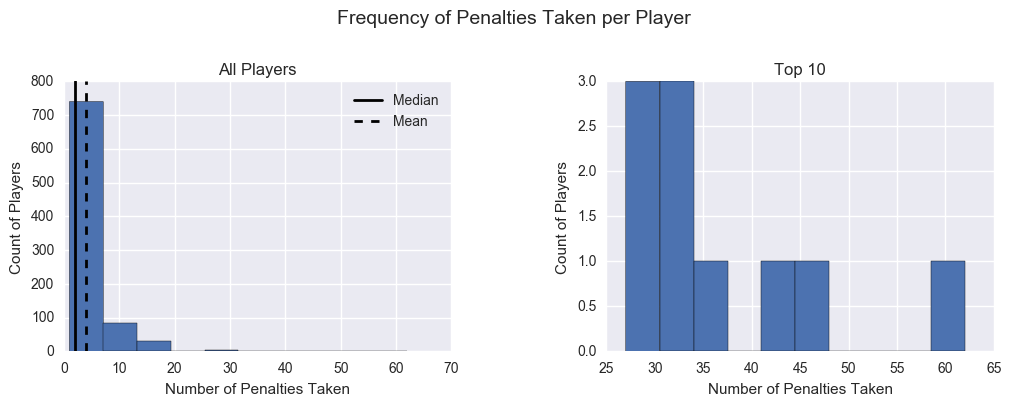

In [102]:
plot_hist2(taken_penalties_df['taken'],'Frequency of Penalties Taken per Player', \
          'All Players','Top 10','Count of Players','Number of Penalties Taken')

#### Penalties Scored
Which players scored the most penalties?

In [103]:
# Count number of penalties scored by each player
scored_penalties_df=penalties_df[penalties_df['scored']==True].groupby('player_id').count()
scored_penalties_df.sort_values(by='match_id',ascending=False,inplace=True)

In [104]:
# Add player data
scored_penalties_df=scored_penalties_df.reset_index().merge(player_df.reset_index(),how='inner',on='player_id')
top10(scored_penalties_df[['player_name','scored']])

,player_name,scored
1,Cristiano Ronaldo,55
2,Zlatan Ibrahimovic,41
3,Lionel Messi,36
4,Francesco Totti,29
5,Antonio Di Natale,28
6,Sejad Salihovic,27
7,Steven Gerrard,25
8,Frank Lampard,25
9,Diego Milito,23
10,Edinson Cavani,23


In [105]:
def percent(count,total):
    return str(round(((float(count)/float(total))*100),2))+'%'

In [106]:
penalty_scorers=len(scored_penalties_df.index)
print('Total number of players who have scored penalties: '+str(penalty_scorers))
print('This represents '+percent(penalty_scorers,penalty_takers)+' of the total number of players who have taken penalties.')

Total number of players who have scored penalties: 742
This represents 85.48% of the total number of players who have taken penalties.


In [107]:
scored_penalties_df[['scored']].describe().round(2).transpose()

,count,mean,std,min,25%,50%,75%,max
scored,742.0,3.78,4.77,1.0,1.0,2.0,5.0,55.0


In [108]:
# Most common number of penalties scored
value,count=most_common(scored_penalties_df['scored'])
print(str(count)+' players scored '+str(value)+' penalty,'+ \
      ' which was the most common number of penalties scored')

304 players scored 1 penalty, which was the most common number of penalties scored


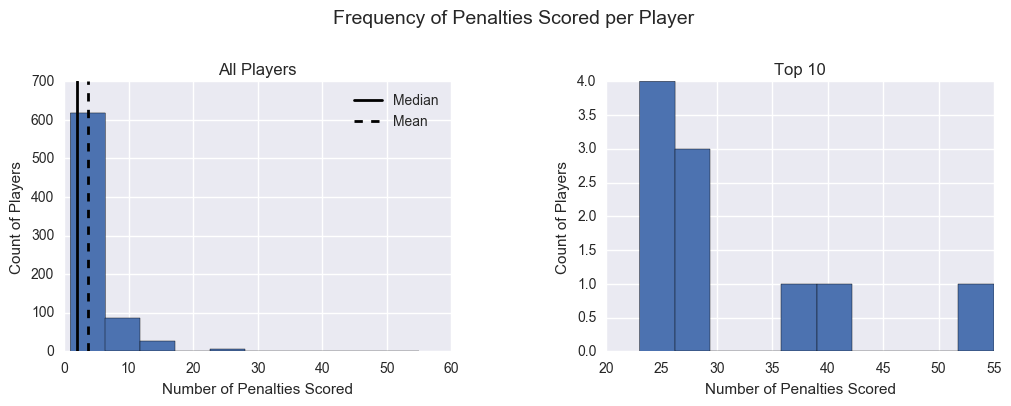

In [109]:
plot_hist2(scored_penalties_df['scored'],'Frequency of Penalties Scored per Player', \
          'All Players','Top 10','Count of Players','Number of Penalties Scored')

In [110]:
all_penalties_df=taken_penalties_df.reset_index()[['player_id','player_name','taken']] \
    .merge(scored_penalties_df.reset_index()[['player_id','scored']],how='left',on='player_id').fillna(0)

#### Penalties Missed
Which players missed the most penalties?

In [111]:
# Count number of penalties missed by each player
missed_penalties_df=penalties_df[penalties_df['scored']==False].groupby('player_id').count()
missed_penalties_df.sort_values(by='match_id',ascending=False,inplace=True)

In [112]:
# Add player data
missed_penalties_df=missed_penalties_df.reset_index().merge(player_df.reset_index(),how='inner',on='player_id') \
    .rename(columns={'scored':'missed'})
top10(missed_penalties_df[['player_name','missed']])

,player_name,missed
1,Edinson Cavani,8
2,Antonio Di Natale,8
3,Lionel Messi,8
4,Marek Hamsik,7
5,Cristiano Ronaldo,7
6,Wayne Rooney,6
7,Klaas Jan Huntelaar,6
8,Frank Lampard,6
9,Barreto,5
10,Wissam Ben Yedder,5


In [113]:
penalty_missers=len(missed_penalties_df.index)
print('Total number of players who have missed penalties: '+str(penalty_missers))
print('This represents '+percent(penalty_missers,penalty_takers)+' of the total number of players who have taken penalties.')

Total number of players who have missed penalties: 441
This represents 50.81% of the total number of players who have taken penalties.


In [114]:
missed_penalties_df[['missed']].describe().round(2).transpose()

,count,mean,std,min,25%,50%,75%,max
missed,441.0,1.57,1.12,1.0,1.0,1.0,2.0,8.0


In [115]:
# Most common number of penalties missed
value,count=most_common(missed_penalties_df['missed'])
print(str(count)+' players missed '+str(value)+' penalty,'+ \
      ' which was the most common number of penalties missed')

301 players missed 1 penalty, which was the most common number of penalties missed


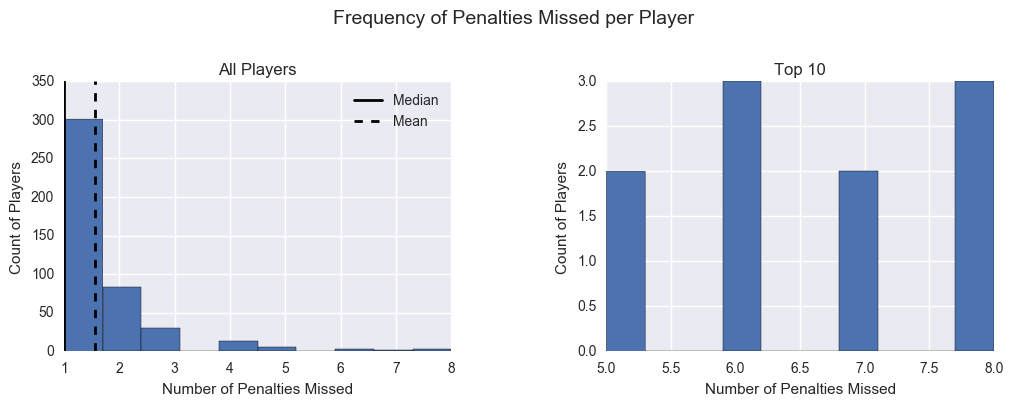

In [116]:
plot_hist2(missed_penalties_df['missed'],'Frequency of Penalties Missed per Player', \
          'All Players','Top 10','Count of Players','Number of Penalties Missed')

In [117]:
all_penalties_df=all_penalties_df.reset_index() \
    .merge(missed_penalties_df.reset_index()[['player_id','missed']],how='left',on='player_id').fillna(0)

In [118]:
all_penalties_df[['taken','scored','missed']].describe().round(2).transpose()

,count,mean,std,min,25%,50%,75%,max
taken,868.0,4.03,5.34,1.0,1.0,2.0,5.0,62.0
scored,868.0,3.23,4.61,0.0,1.0,2.0,4.0,55.0
missed,868.0,0.80,1.12,0.0,0.0,1.0,1.0,8.0


#### Penalty Success Rate
Is there a relationship between number of penalties taken and number of penalties scored, i.e. do players get better at taking penalties with experience?

In [119]:
all_penalties_df['success_rate']=all_penalties_df['scored']/all_penalties_df['taken']
all_penalties_df=all_penalties_df.sort_values(by=['success_rate','taken'],ascending=False)
top10(all_penalties_df[['player_name','taken','scored','missed','success_rate']])

,player_name,taken,scored,missed,success_rate
1,Dimitar Berbatov,10,10.0,0.0,1.0
2,Alessandro Del Piero,10,10.0,0.0,1.0
3,Danny Murphy,10,10.0,0.0,1.0
4,Nene,9,9.0,0.0,1.0
5,Paulo Dybala,9,9.0,0.0,1.0
6,Yaya Toure,9,9.0,0.0,1.0
7,Jeremy Menez,9,9.0,0.0,1.0
8,Andreas Ivanschitz,8,8.0,0.0,1.0
9,Moritz Hartmann,8,8.0,0.0,1.0
10,Xabier Prieto,8,8.0,0.0,1.0


In [120]:
# Players who scored all their penalties
penalty_success_rate_df=all_penalties_df.groupby(['success_rate']).count()
scored_all=penalty_success_rate_df.iloc[len(penalty_success_rate_df.index)-1][0]
print('Total number of players who have 100% penalty scoring success rate: '+str(scored_all))
print('This represents '+percent(scored_all,penalty_takers)+' of the total number of players who have taken penalties.')

Total number of players who have 100% penalty scoring success rate: 427
This represents 49.19% of the total number of players who have taken penalties.


In [121]:
# Players who missed all their penalties
scored_none=penalty_success_rate_df.iloc[0][0]
print('Total number of players who have 0% penalty scoring success rate: '+str(scored_none))
print('This represents '+percent(scored_none,penalty_takers)+' of the total number of players who have taken penalties.')

Total number of players who have 0% penalty scoring success rate: 126
This represents 14.52% of the total number of players who have taken penalties.


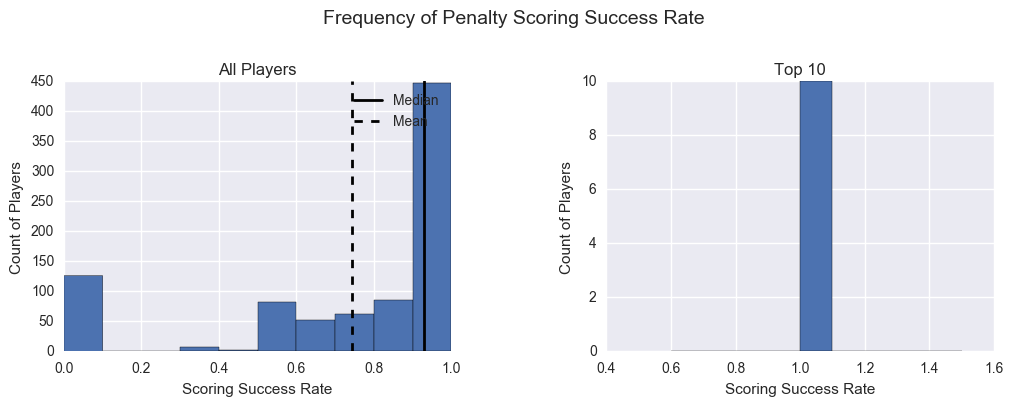

In [122]:
plot_hist2(all_penalties_df['success_rate'],'Frequency of Penalty Scoring Success Rate', \
          'All Players','Top 10','Count of Players','Scoring Success Rate')

In [123]:
def add_trend(x,y):
    # Fit and draw a linear trend line
    z=np.polyfit(x,y,1)
    p=np.poly1d(z)
    plt.plot(x,p(x),"r--")
    return

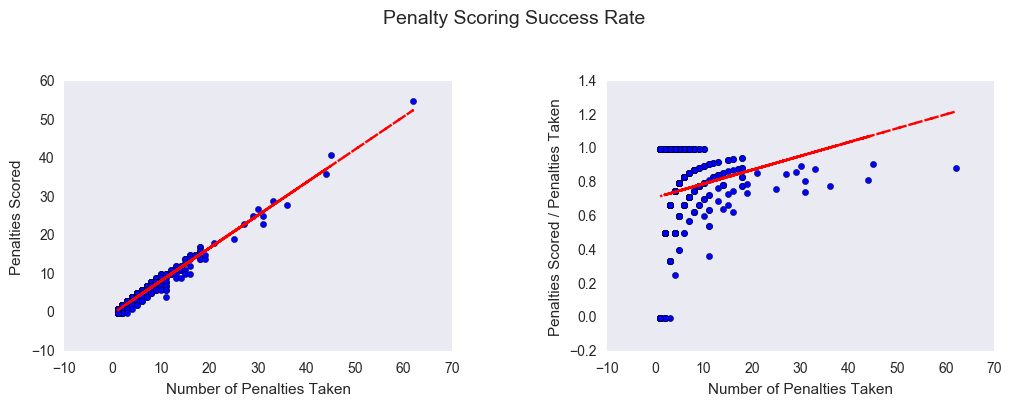

In [124]:
plt.figure(figsize=(12,4))
plt.suptitle('Penalty Scoring Success Rate',fontsize=14)
# Left plot
plt.subplot(1,2,1)
x=all_penalties_df['taken']
y=all_penalties_df['scored']
plt.scatter(x,y)
add_trend(x,y)
#plt.title('Penalty Success Rate')
plt.ylabel('Penalties Scored')
plt.xlabel('Number of Penalties Taken')
plt.grid()
# Right plot
plt.subplot(1,2,2)
x=all_penalties_df['taken']
y=all_penalties_df['success_rate']
plt.scatter(x,y)
add_trend(x,y)
#plt.title('Penalty Success Rate')
plt.ylabel('Penalties Scored / Penalties Taken')
plt.xlabel('Number of Penalties Taken')
plt.subplots_adjust(wspace=0.4,top=0.8)
plt.grid()
plt.show()

#### Penalties Faced
Which goalkeepers faced the most penalties?

In [125]:
keeper_penalties_df=penalties_df[['keeper_id','scored']].rename(columns={'keeper_id':'player_id'})

In [126]:
# Count number of penalties faced by each goalkeeper
faced_penalties_df=keeper_penalties_df.groupby('player_id').count()
faced_penalties_df.sort_values(by='scored',ascending=False,inplace=True)

In [127]:
# Add player data
faced_penalties_df=faced_penalties_df.reset_index().merge(player_df.reset_index(),how='inner',on='player_id') \
    .rename(columns={'scored':'faced'})
top10(faced_penalties_df[['player_name','faced']])

,player_name,faced
1,Samir Handanovic,56
2,Antonio Mirante,47
3,Gorka Iraizoz Moreno,45
4,Stefano Sorrentino,41
5,Diego Lopez,36
6,Andrea Consigli,34
7,Jean-Francois Gillet,31
8,Ben Foster,31
9,Diego Alves,30
10,Federico Marchetti,29


In [128]:
penalty_keepers=len(faced_penalties_df.index)
print('Total number of goalkeepers to face penalties: '+str(penalty_keepers))

Total number of goalkeepers to face penalties: 390


In [129]:
faced_penalties_df[['faced']].describe().round(2).transpose()

,count,mean,std,min,25%,50%,75%,max
faced,390.0,8.97,8.67,1.0,2.0,6.0,13.0,56.0


In [130]:
# Most common number of penalties faced
value,count=most_common(faced_penalties_df['faced'])
print(str(count)+' goalkeepers faced '+str(value)+' penalty,'+ \
      ' which was the most common number of penalties faced')

66 goalkeepers faced 1 penalty, which was the most common number of penalties faced


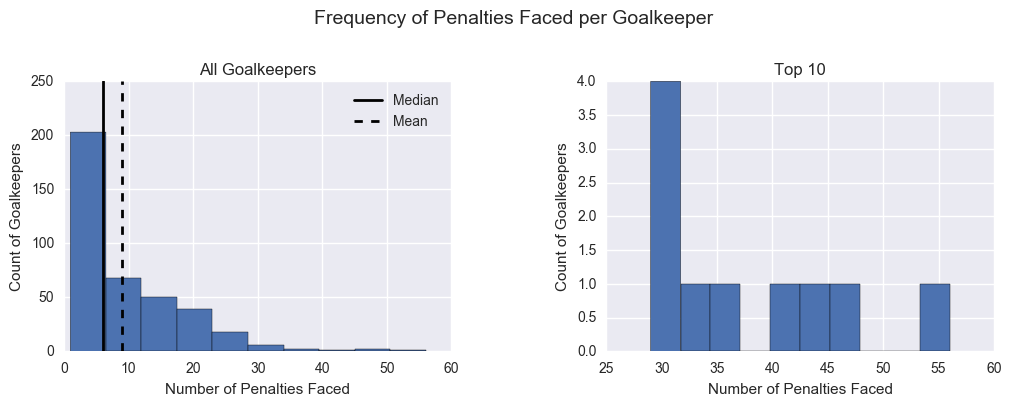

In [131]:
plot_hist2(faced_penalties_df['faced'],'Frequency of Penalties Faced per Goalkeeper', \
          'All Goalkeepers','Top 10','Count of Goalkeepers','Number of Penalties Faced')

#### Penalties Saved
Which goalkeepers saved the most penalties?

In [132]:
# Count number of penalties saved for each goalkeeper
saved_penalties_df=keeper_penalties_df[penalties_df['scored']==False].groupby('player_id').count()
saved_penalties_df.sort_values(by='scored',ascending=False,inplace=True)

In [133]:
# Add player data
saved_penalties_df=saved_penalties_df.reset_index().merge(player_df.reset_index(),how='inner',on='player_id') \
    .rename(columns={'scored':'saved'})
top10(saved_penalties_df[['player_name','saved']])

,player_name,saved
1,Samir Handanovic,22
2,Diego Alves,12
3,Antonio Mirante,12
4,Diego Lopez,10
5,Heurelho Gomes,10
6,Andrea Consigli,10
7,Mattia Perin,9
8,Stefano Sorrentino,8
9,Tim Howard,8
10,Federico Marchetti,8


In [134]:
penalty_savers=len(saved_penalties_df.index)
print('Total number of goalkeepers to save penalties: '+str(penalty_savers))

Total number of goalkeepers to save penalties: 233


In [135]:
saved_penalties_df[['saved']].describe().round(2).transpose()

,count,mean,std,min,25%,50%,75%,max
saved,233.0,2.97,2.52,1.0,1.0,2.0,4.0,22.0


In [136]:
# Most common number of penalties saved
value,count=most_common(saved_penalties_df['saved'])
print(str(count)+' goalkeepers saved '+str(value)+' penalty,'+ \
      ' which was the most common number of penalties saved')

76 goalkeepers saved 1 penalty, which was the most common number of penalties saved


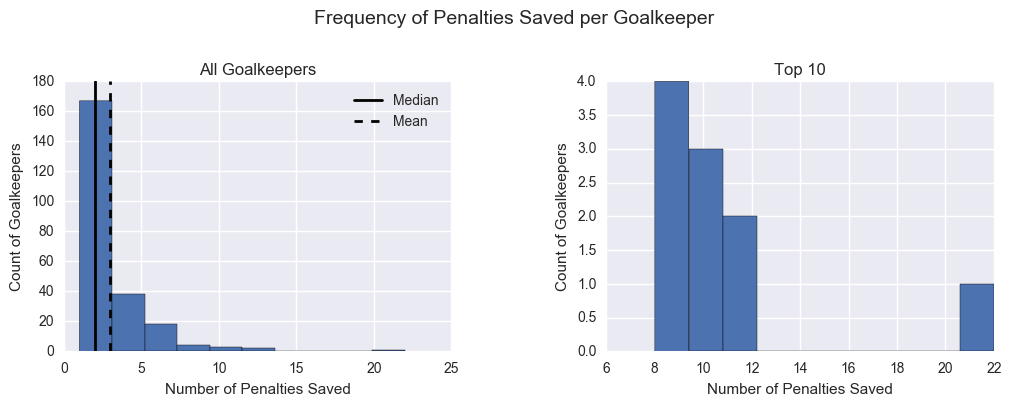

In [137]:
plot_hist2(saved_penalties_df['saved'],'Frequency of Penalties Saved per Goalkeeper', \
          'All Goalkeepers','Top 10','Count of Goalkeepers','Number of Penalties Saved')

In [138]:
all_faced_df=faced_penalties_df.reset_index()[['player_id','player_name','faced']] \
    .merge(saved_penalties_df.reset_index()[['player_id','saved']],how='left',on='player_id').fillna(0)

In [139]:
all_faced_df[['faced','saved']].describe().round(2).transpose()

,count,mean,std,min,25%,50%,75%,max
faced,390.0,8.97,8.67,1.0,2.0,6.0,13.0,56.0
saved,390.0,1.77,2.43,0.0,0.0,1.0,3.0,22.0


#### Penalty Saving Success Rate
Is there a relationship between number of penalties faced and number of penalties saved, i.e. do goalkeepers get better at saving penalties with experience?

In [140]:
all_faced_df['success_rate']=all_faced_df['saved']/all_faced_df['faced']
all_faced_df.sort_values(by=['success_rate','faced'],ascending=False,inplace=True)
top10(all_faced_df[['player_name','faced','saved','success_rate']])

,player_name,faced,saved,success_rate
1,Jaume,2,2.0,1.0
2,Mike Maignan,2,2.0,1.0
3,Jesus Fernandez,2,2.0,1.0
4,Wolfgang Hesl,2,2.0,1.0
5,Karl Darlow,1,1.0,1.0
6,Ruben Blanco,1,1.0,1.0
7,Luca Anania,1,1.0,1.0
8,David Cobeno,1,1.0,1.0
9,Marc Ziegler,1,1.0,1.0
10,Chema,1,1.0,1.0


In [141]:
# Goalkeepers who saved all their penalties
goalkeeper_success_rate_df=all_faced_df.groupby(['success_rate']).count()
saved_all=goalkeeper_success_rate_df.iloc[len(goalkeeper_success_rate_df.index)-1][0]
print('Total number of goalkeepers who have 100% penalty saving success rate: '+str(saved_all))
print('This represents '+percent(saved_all,penalty_keepers)+' of the total number of goalkeepers who have faced penalties.')

Total number of goalkeepers who have 100% penalty saving success rate: 10
This represents 2.56% of the total number of goalkeepers who have faced penalties.


In [142]:
# Goalkeepers who conceded all their penalties
saved_none=goalkeeper_success_rate_df.iloc[0][0]
print('Total number of goalkeepers who have 0% penalty saving success rate: '+str(saved_none))
print('This represents '+percent(saved_none,penalty_keepers)+' of the total number of goalkeepers who have faced penalties.')

Total number of goalkeepers who have 0% penalty saving success rate: 157
This represents 40.26% of the total number of goalkeepers who have faced penalties.


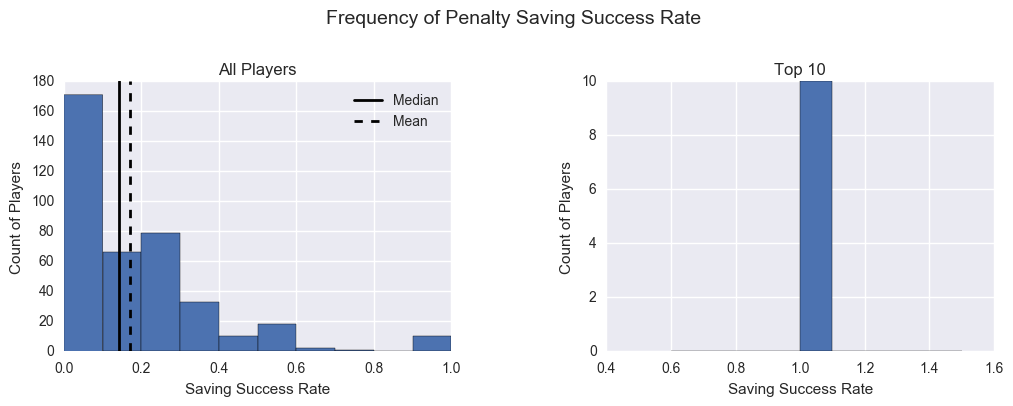

In [143]:
plot_hist2(all_faced_df['success_rate'],'Frequency of Penalty Saving Success Rate', \
          'All Players','Top 10','Count of Players','Saving Success Rate')

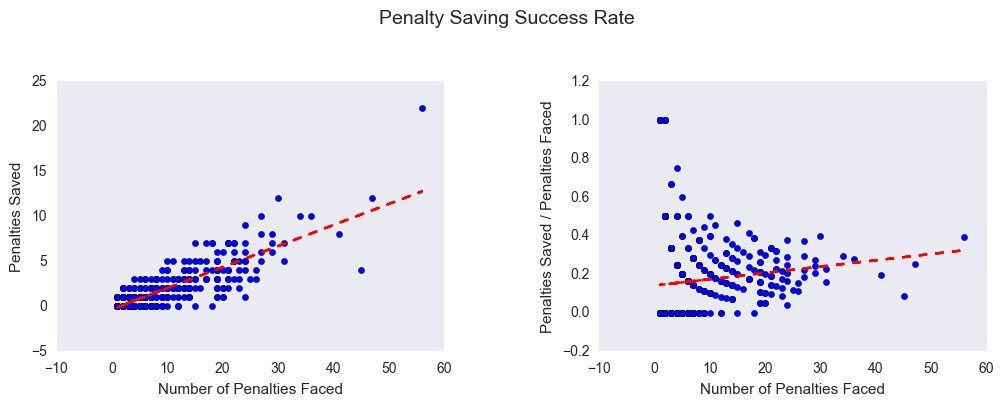

In [144]:
plt.figure(figsize=(12,4))
plt.suptitle('Penalty Saving Success Rate',fontsize=14)
# Left plot
plt.subplot(1,2,1)
x=all_faced_df['faced']
y=all_faced_df['saved']
plt.scatter(x,y)
add_trend(x,y)
#plt.title('Penalty Success Rate')
plt.ylabel('Penalties Saved')
plt.xlabel('Number of Penalties Faced')
plt.grid()
# Right plot
plt.subplot(1,2,2)
x=all_faced_df['faced']
y=all_faced_df['success_rate']
plt.scatter(x,y)
add_trend(x,y)
#plt.title('Penalty Success Rate')
plt.ylabel('Penalties Saved / Penalties Faced')
plt.xlabel('Number of Penalties Faced')
plt.subplots_adjust(wspace=0.4,top=0.8)
plt.grid()
plt.show()

#### Penalties Conceded
Which teams conceded the most penalties?

In [145]:
# Count number of penalties conceded by each team
conceded_penalties_df=penalties_df.groupby('opponent_id').count()['scored']
conceded_penalties_df=conceded_penalties_df.reset_index() \
    .rename(columns={'opponent_id':'team_id','scored':'conceded'})

In [146]:
# Add team name
conceded_penalties_df=conceded_penalties_df.merge(team_df.reset_index(),how='inner',on='team_id').set_index('team_id')
conceded_penalties_df.sort_values(by='conceded',ascending=False,inplace=True)
top10(conceded_penalties_df[['team_name','conceded']])

,team_name,conceded
1,Udinese,61
2,Palermo,49
3,Genoa,49
4,Getafe CF,48
5,Inter,48
6,Lazio,47
7,Valencia CF,47
8,Aston Villa,46
9,Athletic Club de Bilbao,46
10,Atalanta,46


In [147]:
conceding_teams=len(conceded_penalties_df.index)
print('Total number of different teams to concede penalties: '+str(conceding_teams))

Total number of different teams to concede penalties: 159


In [148]:
conceded_penalties_df[['conceded']].describe().round(2).transpose()

,count,mean,std,min,25%,50%,75%,max
conceded,159.0,22.0,13.82,2.0,9.0,22.0,31.0,61.0


In [149]:
# Most common number of penalties conceded
value,count=most_common(conceded_penalties_df['conceded'])
print(str(count)+' teams conceded '+str(value)+' penalties,'+ \
      ' which was the most common number of penalties conceded')

11 teams conceded 16 penalties, which was the most common number of penalties conceded


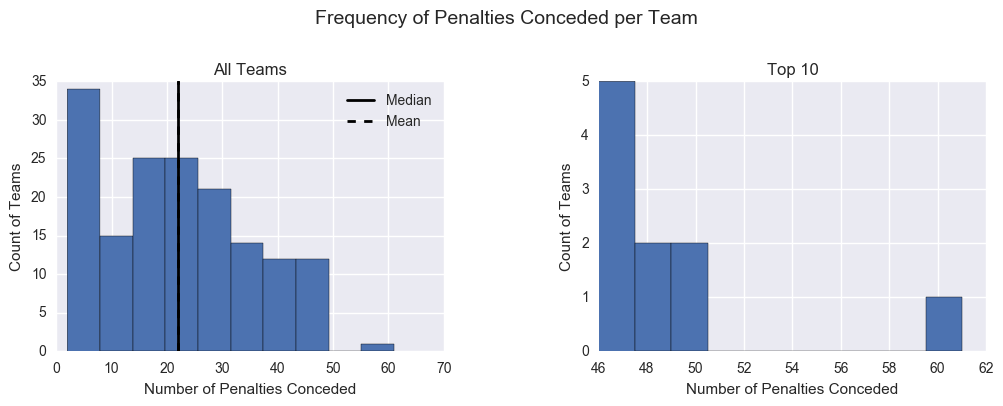

In [150]:
plot_hist2(conceded_penalties_df['conceded'],'Frequency of Penalties Conceded per Team', \
          'All Teams','Top 10','Count of Teams','Number of Penalties Conceded')

#### Interesting Fact
How many goalkeepers have taken/scored penalties?

In [151]:
# Get list of all goalkeepers
goalkeepers_df=match_subset_df[['home_player_1','away_player_1']]
goalkeepers_df=goalkeepers_df.stack(dropna=True).astype(int).reset_index()
goalkeepers_list=list(goalkeepers_df[0].unique())
print('Total number of different goalkeepers: '+str(len(goalkeepers_list)))

Total number of different goalkeepers: 517


In [152]:
# Find any goalkeepers who have taken penalties
goalkeeper_penalty_df=penalties_df[(penalties_df['player_id'].isin(goalkeepers_list))]
print('Total number of goalkeepers to take penalties: '+str(len(goalkeeper_penalty_df.index)))

Total number of goalkeepers to take penalties: 1


In [153]:
penalty=goalkeeper_penalty_df.iloc[0]
name=player_df.loc[penalty['player_id'],'player_name']
outcome='scored' if penalty['scored'] else 'missed'
team=team_df.loc[penalty['team_id'],'team_name']
opponent=team_df.loc[penalty['opponent_id'],'team_name']
season=match_subset_df.set_index('match_id').loc[penalty['match_id'],'season']
print('Goalkeeper '+name+' '+outcome+' a penalty for '+team+' against '+opponent+' in the '+season+' season.')

Goalkeeper Hans-Joerg Butt missed a penalty for FC Bayern Munich against 1. FSV Mainz 05 in the 2009/2010 season.


***

### Research Area 3 - Fouls

#### Fouls Committed by Player
Which players committed the most fouls?

In [154]:
# Count number of fouls committed by each player
player_fouls_df=fouls_df.groupby(['player_id']).count()
player_fouls_df.sort_values(by='match_id',ascending=False,inplace=True)

In [155]:
# Add player data
player_fouls_df=player_fouls_df.reset_index().merge(player_df.reset_index(),how='inner',on='player_id') \
    .rename(columns={'match_id':'fouls'}).set_index([range(1,len(player_fouls_df)+1)])
top10(player_fouls_df[['player_name','fouls']])

,player_name,fouls
1,Marouane Fellaini,427
2,Gareth Barry,380
3,Lucas Leiva,307
4,Kevin Davies,293
5,Lee Cattermole,288
6,Cheik Tiote,286
7,Gabriel Agbonlahor,258
8,Daniel Alves,258
9,Alex Song,250
10,Steven Nzonzi,247


In [156]:
player_fouls_df[['fouls']].describe().round(2).transpose()

,count,mean,std,min,25%,50%,75%,max
fouls,4754.0,37.73,42.19,1.0,7.0,23.0,55.0,427.0


In [157]:
# Most common number of fouls committed
value,count=most_common(player_fouls_df['fouls'])
print(str(count)+' players committed '+str(value)+' foul,'+ \
      ' which was the most common number of fouls committed')

311 players committed 1 foul, which was the most common number of fouls committed


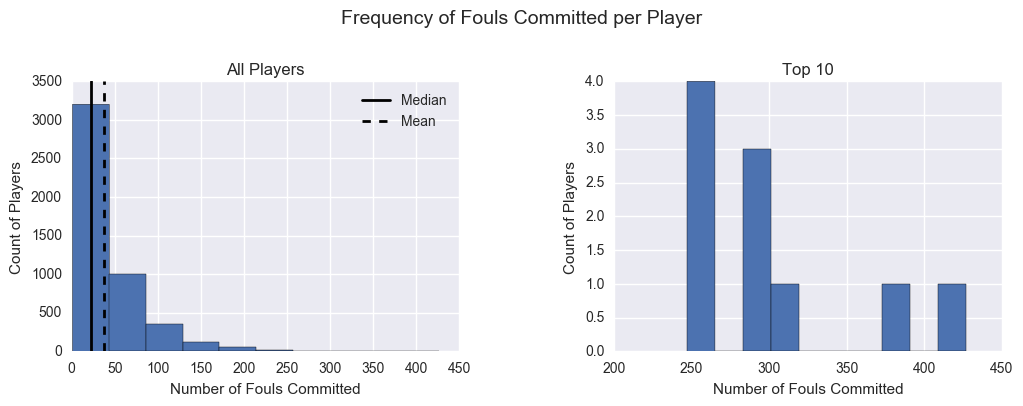

In [158]:
plot_hist2(player_fouls_df['fouls'],'Frequency of Fouls Committed per Player', \
          'All Players','Top 10','Count of Players','Number of Fouls Committed')

In [159]:
# Add total appearances
player_fouls_df=player_fouls_df.merge(total_appearances_df.reset_index(),how='inner',on='player_id')
player_fouls_df['fouls_per_match']=(player_fouls_df['fouls']/player_fouls_df['appearances']).round(2)
player_fouls_df.sort_values(by='fouls_per_match',ascending=False,inplace=True)
top10(player_fouls_df[['player_name','fouls','appearances','fouls_per_match']])

,player_name,fouls,appearances,fouls_per_match
1,Rafa Galvez,6,1,6.0
2,Lucas Souza,7,2,3.5
3,Kevin Soni,3,1,3.0
4,Carlos Carbonero,84,28,3.0
5,Lukas Froede,3,1,3.0
6,Javier Noblejas,3,1,3.0
7,Leon Guwara,3,1,3.0
8,Nicola Strambelli,3,1,3.0
9,Emiliano Alfaro,3,1,3.0
10,Bruno Perone,3,1,3.0


In [160]:
player_fouls_df[['fouls_per_match']].describe().round(2).transpose()

,count,mean,std,min,25%,50%,75%,max
fouls_per_match,4754.0,0.72,0.48,0.0,0.37,0.63,1.0,6.0


In [161]:
# Most common number of fouls committed per match
value,count=most_common(player_fouls_df['fouls_per_match'])
print(str(count)+' players committed '+str(value)+' foul per match,'+ \
      ' which was the most common number of fouls committed per match')

221 players committed 1.0 foul per match, which was the most common number of fouls committed per match


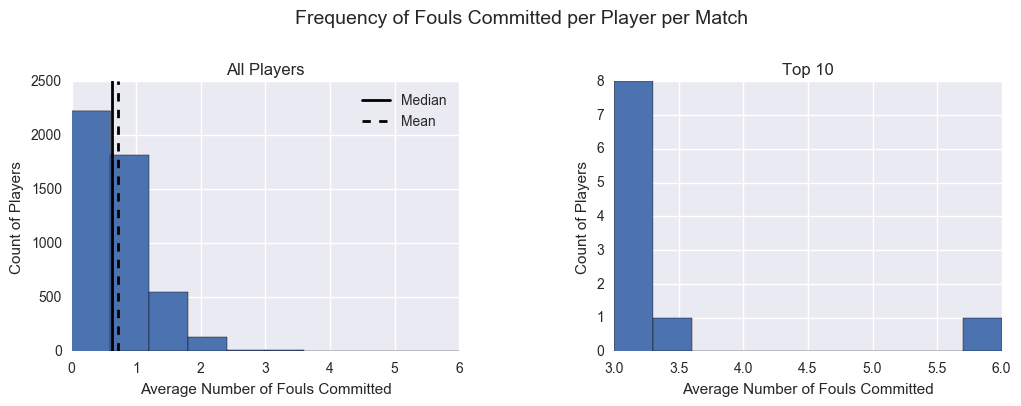

In [162]:
plot_hist2(player_fouls_df['fouls_per_match'],'Frequency of Fouls Committed per Player per Match', \
          'All Players','Top 10','Count of Players','Average Number of Fouls Committed')

#### Fouls Against Player
Which players were fouled the most?

In [163]:
# Count number of times each player was fouled
player_fouled_df=fouls_df[['opponent_id','match_id']].rename(columns={'opponent_id':'player_id'}).groupby(['player_id']).count()
player_fouled_df.sort_values(by='match_id',ascending=False,inplace=True)

In [164]:
# Add player data
player_fouled_df=player_fouled_df.reset_index().merge(player_df.reset_index(),how='inner',on='player_id') \
    .rename(columns={'match_id': 'fouled'})
top10(player_fouled_df[['player_name','fouled']])

,player_name,fouled
1,Lionel Messi,401
2,Cristiano Ronaldo,396
3,Ashley Young,376
4,Steven Pienaar,363
5,Eden Hazard,327
6,Luis Suarez,322
7,Leighton Baines,319
8,Sergio Busquets,316
9,Jonas Gutierrez,300
10,Gabriel Agbonlahor,292


In [165]:
player_fouled_df[['fouled']].describe().round(2).transpose()

,count,mean,std,min,25%,50%,75%,max
fouled,4820.0,37.04,45.98,1.0,6.0,20.0,51.0,401.0


In [166]:
# Most common number of times fouled
value,count=most_common(player_fouled_df['fouled'])
print(str(count)+' players were fouled '+str(value)+' time,'+ \
      ' which was the most common number of times players were fouled')

323 players were fouled 1 time, which was the most common number of times players were fouled


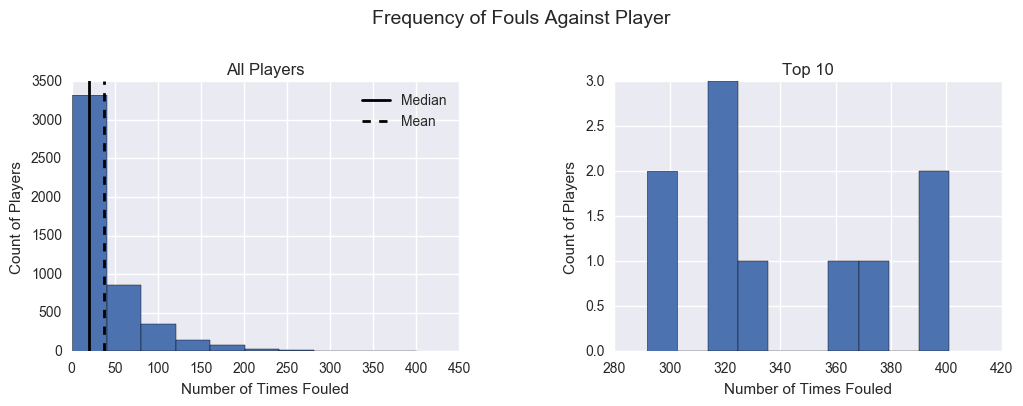

In [167]:
plot_hist2(player_fouled_df['fouled'],'Frequency of Fouls Against Player', \
          'All Players','Top 10','Count of Players','Number of Times Fouled')

In [168]:
# Add total appearances
player_fouled_df=player_fouled_df.merge(total_appearances_df.reset_index(),how='inner',on='player_id')
player_fouled_df['fouled_per_match']=(player_fouled_df['fouled']/player_fouled_df['appearances']).round(2)
player_fouled_df.sort_values(by='fouled_per_match',ascending=False,inplace=True)
top10(player_fouled_df[['player_name','fouled','appearances','fouled_per_match']])

,player_name,fouled,appearances,fouled_per_match
1,Giles Barnes,7,1,7.0
2,Danilo Soares,6,1,6.0
3,Aaron Doran,5,1,5.0
4,Rico Strieder,5,1,5.0
5,Steve De Ridder,4,1,4.0
6,Emiliano Alfaro,4,1,4.0
7,Raffaele Maiello,24,6,4.0
8,Lucas Evangelista,8,2,4.0
9,Leon Guwara,4,1,4.0
10,Daniele Verde,7,2,3.5


In [169]:
player_fouled_df[['fouled_per_match']].describe().round(2).transpose()

,count,mean,std,min,25%,50%,75%,max
fouled_per_match,4811.0,0.67,0.55,0.01,0.29,0.54,0.94,7.0


In [170]:
# Most common number of times fouled per match
value,count=most_common(player_fouled_df['fouled_per_match'])
print(str(count)+' players were fouled '+str(value)+' time per match,'+ \
      ' which was the most common number of times players were fouled per match')

183 players were fouled 1.0 time per match, which was the most common number of times players were fouled per match


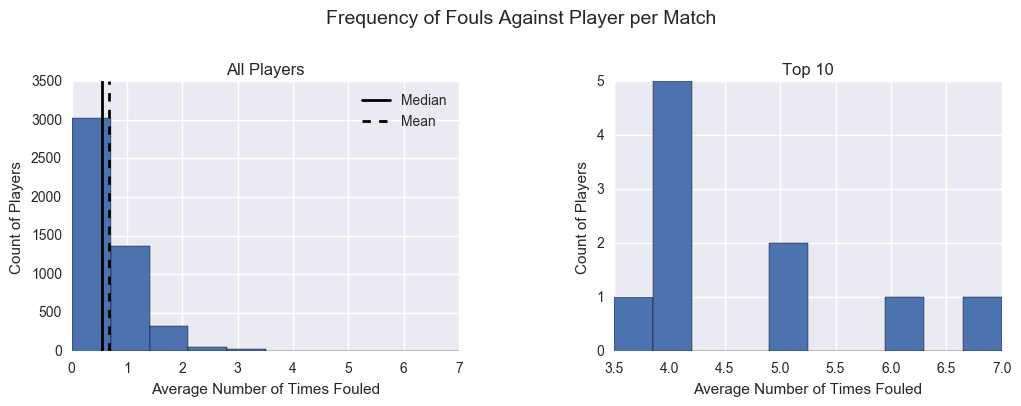

In [171]:
plot_hist2(player_fouled_df['fouled_per_match'],'Frequency of Fouls Against Player per Match', \
          'All Players','Top 10','Count of Players','Average Number of Times Fouled')

#### Fouls Committed by Team
Which teams committed the most fouls?

In [172]:
# Count number of times each team committed fouls
team_fouls_df=fouls_df.groupby('team_id').count()['match_id']
team_fouls_df=team_fouls_df.reset_index().rename(columns={'match_id':'fouls'})

In [173]:
# Add team name
team_fouls_df=team_df.reset_index().merge(team_fouls_df,how='inner',on='team_id')
team_fouls_df.sort_values(by='fouls',ascending=False,inplace=True)
top10(team_fouls_df[['team_name','fouls']])

,team_name,fouls
1,Stoke City,3152
2,Aston Villa,3025
3,Manchester City,2971
4,Manchester United,2961
5,Sunderland,2910
6,Tottenham Hotspur,2888
7,Liverpool,2884
8,Chelsea,2841
9,Everton,2818
10,Arsenal,2763


In [174]:
team_fouls_df[['fouls']].describe().round(2).transpose()

,count,mean,std,min,25%,50%,75%,max
fouls,149.0,1203.71,803.37,16.0,533.0,1061.0,1675.0,3152.0


In [175]:
# Most common number of fouls committed by teams
value,count=most_common(team_fouls_df['fouls'])
print(str(count)+' teams committed '+str(value)+' fouls,'+ \
      ' which was the most common number of fouls committed by teams')

2 teams committed 118 fouls, which was the most common number of fouls committed by teams


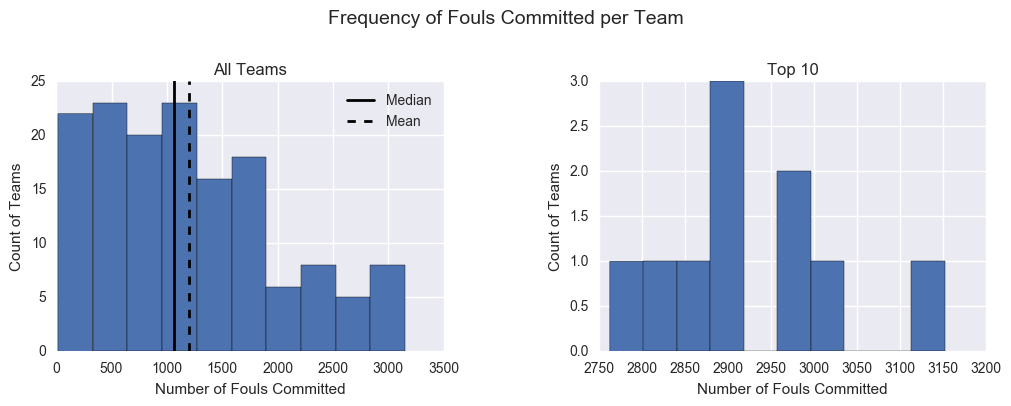

In [176]:
plot_hist2(team_fouls_df['fouls'],'Frequency of Fouls Committed per Team', \
          'All Teams','Top 10','Count of Teams','Number of Fouls Committed')

In [177]:
team_matches_df=appearances_df.groupby('team_id').count()[['match_id']].rename(columns={'match_id':'matches'})

In [178]:
# Add total matches
team_fouls_df=team_fouls_df.merge(team_matches_df.reset_index(),how='inner',on='team_id')
team_fouls_df['fouls_per_match']=(team_fouls_df['fouls']/team_fouls_df['matches']).round(2)
team_fouls_df.sort_values(by='fouls_per_match',ascending=False,inplace=True)
top10(team_fouls_df[['team_name','fouls','matches','fouls_per_match']])

,team_name,fouls,matches,fouls_per_match
1,Frosinone,598,451,1.33
2,SV Darmstadt 98,520,400,1.30
3,Carpi,576,460,1.25
4,SD Eibar,1085,910,1.19
5,GFC Ajaccio,533,447,1.19
6,FC Ingolstadt 04,482,406,1.19
7,FC Metz,521,441,1.18
8,SC Paderborn 07,443,403,1.10
9,Angers SCO,471,451,1.04
10,Empoli,924,916,1.01


In [179]:
team_fouls_df[['fouls_per_match']].describe().round(2).transpose()

,count,mean,std,min,25%,50%,75%,max
fouls_per_match,149.0,0.6,0.26,0.01,0.43,0.57,0.8,1.33


In [180]:
# Most common number of fouls committed by teams per match
value,count=most_common(team_fouls_df['fouls_per_match'])
print(str(count)+' teams committed '+str(value)+' fouls per match,'+ \
      ' which was the most common number of fouls committed by teams per match')

7 teams committed 0.57 fouls per match, which was the most common number of fouls committed by teams per match


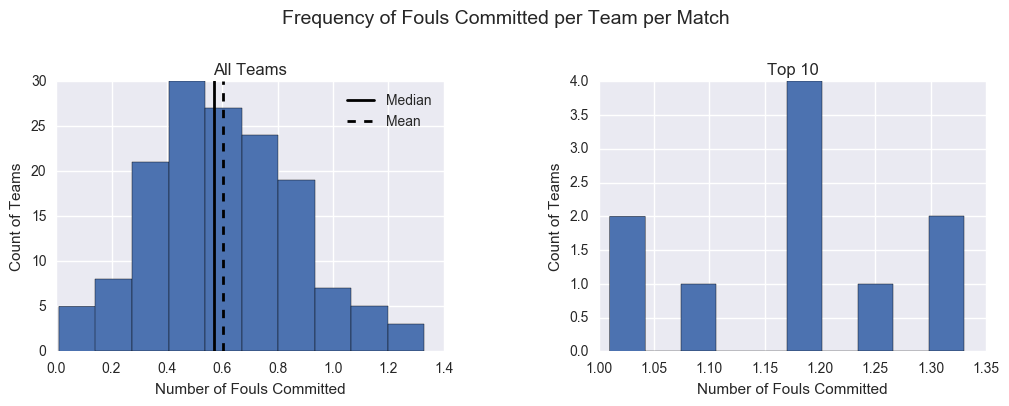

In [181]:
plot_hist2(team_fouls_df['fouls_per_match'],'Frequency of Fouls Committed per Team per Match', \
          'All Teams','Top 10','Count of Teams','Number of Fouls Committed')

#### Fouls Committed by League
In which leagues were the most fouls committed?

In [182]:
# Count number of fouls committed in each league
league_fouls_df=fouls_df.groupby('league_id').count()['match_id']
league_fouls_df=league_fouls_df.reset_index().rename(columns={'match_id':'fouls'})

In [183]:
# Add league name
league_fouls_df=league_fouls_df.merge(league_df.reset_index(),how='inner',on='league_id')
league_fouls_df.sort_values(by='fouls',ascending=False,inplace=True)
top10(league_fouls_df[['league_name','fouls']]) # all leagues displayed since number < 10

,league_name,fouls
1,England Premier League,58390
2,Italy Serie A,38138
3,Spain LIGA BBVA,36631
4,Germany 1. Bundesliga,27428
5,France Ligue 1,18766


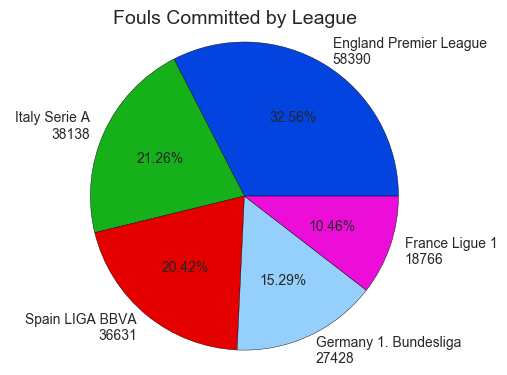

In [184]:
league_fouls_df['labels']=league_fouls_df['league_name']+'\n'+league_fouls_df['fouls'].map(str)
plt.suptitle('Fouls Committed by League',fontsize=14)
plt.pie(league_fouls_df['fouls'],labels=league_fouls_df['labels'],colors=colors,autopct='%.2f%%')
plt.axis('equal')
plt.show()

####  Aggressiveness
Does player aggressiveness (in terms of fouls committed per game) increase or deacrease with age?

In [185]:
# Count number of fouls committed per match by each player
player_fouls_per_match=fouls_df.groupby(['match_id','player_id']).count().rename(columns={'team_id':'fouls'})[['fouls']]

In [186]:
# Add player ages
player_fouls_per_match=player_fouls_per_match.reset_index() \
    .merge(appearances_df.reset_index(),how='inner',on=['match_id','player_id'])
player_fouls_per_match_per_age=player_fouls_per_match.groupby(['age_in_years'])[['fouls']].sum()
player_fouls_per_match_per_age['mean']=player_fouls_per_match.groupby(['age_in_years'])[['fouls']].mean()

In [187]:
player_fouls_per_match_per_age[['fouls','mean']].describe().round(2).transpose()

,count,mean,std,min,25%,50%,75%,max
fouls,26.0,6898.19,6523.72,1.0,546.00,4923.50,13140.75,17385.00
mean,26.0,1.56,0.16,1.0,1.56,1.64,1.65,1.67


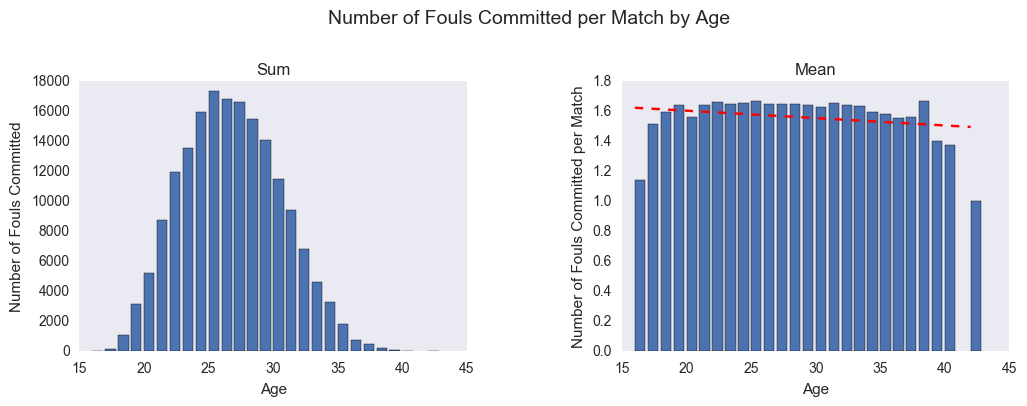

In [188]:
plt.figure(figsize=(12,4))
plt.suptitle('Number of Fouls Committed per Match by Age',fontsize=14)
# Left plot
plt.subplot(1,2,1)
x=player_fouls_per_match_per_age.index
y=player_fouls_per_match_per_age['fouls']
plt.bar(x,y)
plt.title('Sum')
plt.ylabel('Number of Fouls Committed')
plt.xlabel('Age')
plt.grid()
# Right plot
plt.subplot(1,2,2)
y=player_fouls_per_match_per_age['mean']
plt.bar(x,y)
plt.title('Mean')
plt.ylabel('Number of Fouls Committed per Match')
plt.xlabel('Age')
plt.subplots_adjust(wspace=0.4,top=0.8)
plt.grid()
add_trend(x,y)
plt.show()

***

<a id='conclusions'></a>
## Conclusions

### The Dataset

The dataset consisted of match, team and player data from the lead championships of 11 European Countries, from seasons 2008 to 2016. An initial analysis found several duplicate team entries and lots of missing data. The match events data, required to answer the questions posed, was missing for many of the leagues. A subset of data was selected based on the leagues that contained sufficient match events. This was then further reduced by removing all entries that didn't contain match events. The final subset of match data contained details for 14585 matches.

The match events data contained all the information regarding penalties and fouls in xml format. These were extracted and filterd to remove any incomplete entries, and further reduced by removing any entries containing unknown players.

The initial match data only recorded the starting line-ups for each team for each match, and not substitutes. Since many substitutes took penalties or committed fouls, they needed to be added to the team line-ups for the relevant matches. A table of appearences was created using the initial match line-ups supplemented by the players from the extracted penalty and foul events.

The final appearance data consisted of 309795 individual player appearances from 5936 different players. The players with the highest number of appearances were Samir Handanovic and Gorka Iraizoz Moreno, both with 286 appearances. The distribution of the number of appearances per player was found to be positively skewed, with a mean of 52.19 appearances and a standard deviation of 54.55 appearances. 336 players only played 1 match, which was the most common number of appearances per player.

The player ages were calculated in both days and years. The distribution of the number of appearances per player age was found to be normally distributed, centred around a mean of 26.61 years (9904.58 days) with a standard deviation of 4.01 years (1458.52 days). 28596 players were 25 years old on match day, which was the most common player age.


### Research Areas 

#### 1 - Ages
The oldest player to play in the top leagues was Francesco Antonioli for Cesena in Italy Serie A, who was 42 years (15575 days) on 2012-05-06.
The youngest player to play in the top leagues was Fabrice Olinga for Málaga CF in Spain LIGA BBVA,	who was 16 years (5956 days) on 2012-09-01.
The distribution of the number of appearances per mean team age was found to be normally distributed, centred around a mean of 26.62 years (9905.17 days) with a standard deviation of 1.47 years (536.00 days). This is practically identical to the mean ages of all the players on which they are based. However the standard distribution of mean team ages is smaller than that for all the players, meaning that the age range in each team is smaller than the age range for all the players. 629 teams had a mean age of 27.0 years, which was the most common mean team age.
The oldest team to play in the top leagues was Milan, with an average team age of 33.09 years (12274.45 days).
The youngest team to play in the top leagues was OGC Nice, with an average team age of 21.09 years (7898.36 days).

#### 2 - Penalties
Our subset of data contained details of 3498 penalties, taken by 868 different players.
The player who took the most penalties was Cristiano Ronaldo, who took 62 penalties.
The mean number of penalties taken per player, of those players who have taken penalties, was 4.03 penalties, with a standard deviation of 5.34 penalties. 357 players took 1 penalty, which was the most common number of penalties taken.

The total number of penalties scored was 2806 penalties, which represents 7.65% of all the goals scored. The penalties were scored by 742 different players, which represents 85.48% of all the players who have taken penalties.
The player who scored the most penalties was Cristiano Ronaldo, who scored 55 out of 62 penalties.
Of all the players who have taken penalties, the mean number of penalties scored per player was 3.23 penalties, with a standard deviation of 4.61 penalties. 304 players scored 1 penalty, which was the most common number of penalties scored.

441 players missed penalties, which represents 50.81% of all the players who have taken penalties.
The players who missed the most penalties were Antonio Di Natale who missed 8 out of 31 penalties, Edinson Cavani who missed 8 out of 36 penalties, and Lionel Messi, who missed 8 out of 44 penalties. Of all the players who have taken penalties, the mean number of penalties missed per player was 0.80 penalties, with a standard deviation of 1.12 penalties. 301 players missed 1 penalties, which was the most common number of penalties missed.

427 players were found to have scored all of their penalties, which represents 49.19% of all the players who have taken penalties.
126 players were found to have missed all of their penalties, which represents 14.52% of all the players who have taken penalties.
The general trend is that players do get better at taking penalties with experience.

There were 517 different goalkeepers in out subset of data, and of those 390 have faced penalties. 
The goalkeeper who faced the most penalties was Samir Handanovic, who faced 56 penalties.
Of all the goalkeepers who faced penalties, the mean number of penalties faced was 8.97 penalties, with a standard deviation of 8.67 penalties. 66 goalkeepers faced 1 penalty, which was the most common number of penalties faced.
The goalkeeper who saved the most penalties was also Samir Handanovic, who saved 22 out of 56 penalties.
Of all the goalkeepers who faced penalties, the mean number of penalties saved was 1.77 penalties, with a standard deviation of 2.43 penalties. 76 goalkeepers saved 1 penalty, which was the most common number of penalties saved.

10 goalkeepers were found to have saved all of the penalties they faced, which represents 2.56% of all the goalkeepers who faced penalties.
157 goalkeepers were found to have saved none of the penalties they faced, which represents 40.26% of all the goalkeepers who faced penalties.
The general trend is that goalkeepers do get better at saving penalties with experience.

Of the 159 teams that conceded penalties, the team that conceded the most penalties was Udinese, with 62 penalties conceded.
The mean number of penalties conceded per team was 22.0 penalties, with a standard deviation of 13.82 penalties. 11 teams conceded 16 penalties, which was the most common number of penalties conceded.

It was also found that the only goalkeeper to take a penalty was Hans-Joerg Butt, who missed a penalty for FC Bayern Munich against 1. FSV Mainz 05 in the 2009/2010 season.

#### 3 - Fouls
A total of 179353 fouls were committed by 4754 different players, against 4820 different players.

The player who committed the most fouls was Marouane Fellaini, who committed 427 fouls in 191 appearances.
However, Rafa Galvez committed the most fouls in a single game, with 6 fouls in 1 appearance.
The distribution of fouls committed per player was very positively skewed, with a mean of 37.73 fouls and a standard deviation of 42.19 fouls. 311 players committed 1 foul, which was the most common number of fouls committed.
The distribution of fouls committed per player per match was also positively skewed, with a mean of 0.72 fouls and a standard deviation of 0.48 fouls. 221 players committed 1.0 foul per match, which was the most common number of fouls committed per match.

The player who was fouled the most was Lionel Messi, who was fouled 401 times in 254 appearances.
However, Giles Barnes was fouled the most in a single game, with 7 fouls in 1 appearance.
The distribution of fouls against each player was positively skewed, with a mean of 37.04 fouls and a standard deviation of 45.98 fouls. 323 players were fouled once, which was the most common number of times players were fouled.
The distribution of fouls against each player per match was also positively skewed, with a mean of 0.67 fouls and a standard deviation of 0.55 fouls. 183 players were fouled once per match, which was the most common number of times players were fouled per match.

Of the 149 different teams to committed fouls, the team that committed the most fouls was Stoke City, with 3152 fouls in 3560 matches.
However, Frosinone had the highest foul-per-game ratio of 1.33, with 598 fouls in 451 matches.
The distribution of fouls committed per team was positively skewed, with a mean of 1203.71 fouls and a standard deviation of 803.37 fouls. 2 teams committed 118 fouls, which was the most common number of fouls committed by teams.
The distribution of fouls committed per team per match was normally distributed, with a mean of 0.60 fouls and a standard deviation of 0.26 fouls. 7 teams committed 0.57 fouls per match, which was the most common number of fouls committed by teams per match.

The league in which most fouls were committed was England Premier League, with 58390 fouls (32.56% of all fouls committed).

Player aggressiveness (in terms of the mean number of fouls committed per game) is almost uniformly distributed with age, with a mean of 1.56 fouls and a standard deviation of 0.16 fouls. The mean number of fouls increases initially, but then deacreases slightly with age. This means that, with the exception of the very youngest and very oldest players, age has little effect on player aggressiveness and only decreases slightly with age.
